# ETAD MAC-Speciation Analysis
# Comprehensive analysis of MAC methods and chemical speciation for Addis Ababa, Ethiopia
# Modified to show all graphs individually instead of as collages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')


# %%
# Set publication-quality style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'font.size': 11,
    'axes.labelsize': 13,
    'axes.titlesize': 15,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 10,
    'figure.titlesize': 16
})

## 1. Data Loading and Unit Handling

In [2]:
def load_etad_ftir_data(db_path):
    """Load FTIR/HIPS data for ETAD with proper units"""
    
    print("📊 Loading FTIR/HIPS data...")
    
    try:
        conn = sqlite3.connect(db_path)
        
        query = """
        SELECT 
            f.filter_id, f.sample_date, f.site_code, m.volume_m3,
            m.ec_ftir, m.ec_ftir_mdl, m.oc_ftir, m.oc_ftir_mdl,
            m.fabs, m.fabs_mdl, m.fabs_uncertainty, m.ftir_batch_id
        FROM filters f
        JOIN ftir_sample_measurements m USING(filter_id)
        WHERE f.site_code = 'ETAD' AND
              m.ec_ftir IS NOT NULL AND
              m.oc_ftir IS NOT NULL AND
              m.fabs IS NOT NULL
        ORDER BY f.sample_date
        """
        
        df = pd.read_sql_query(query, conn)
        df['sample_date'] = pd.to_datetime(df['sample_date'])
        conn.close()
        
        # Clean data - handle values below MDL
        for col, mdl_col in [('ec_ftir', 'ec_ftir_mdl'), ('oc_ftir', 'oc_ftir_mdl'), ('fabs', 'fabs_mdl')]:
            mask_below_mdl = df[col] < df[mdl_col]
            if mask_below_mdl.sum() > 0:
                df.loc[mask_below_mdl, col] = df.loc[mask_below_mdl, mdl_col] / 2
        
        # Calculate additional parameters
        df['oc_ec_ratio'] = df['oc_ftir'] / df['ec_ftir']
        df['mac_individual'] = df['fabs'] / df['ec_ftir']  # m²/g
        
        # Remove extreme outliers
        df_clean = df[(df['mac_individual'] < 50) & (df['oc_ec_ratio'] < 20)]
        
        print(f"✅ Loaded {len(df_clean)} FTIR/HIPS samples")
        print(f"   Date range: {df_clean['sample_date'].min()} to {df_clean['sample_date'].max()}")
        print(f"   Units: EC/OC (μg/m³), Fabs (Mm⁻¹), MAC (m²/g)")
        
        return df_clean
        
    except Exception as e:
        print(f"❌ Error loading FTIR data: {e}")
        return None

def load_etad_speciation_data(csv_path):
    """Load ETAD speciation data with proper unit handling"""
    
    print("🧪 Loading speciation data...")
    
    try:
        # Load CSV (skip first 3 lines to get to header)
        df = pd.read_csv(csv_path, skiprows=3)
        print(f"   Raw data: {len(df)} rows, {len(df.columns)} columns")
        
        # Filter for ETAD
        df = df[df['Site_Code'] == 'ETAD'].copy()
        print(f"   ETAD data: {len(df)} rows")
        
        # Create datetime
        def create_timestamp(row):
            try:
                return pd.Timestamp(
                    year=int(row['Start_Year_local']),
                    month=int(row['Start_Month_local']),
                    day=int(row['Start_Day_local']),
                    hour=int(row['Start_hour_local'])
                )
            except:
                return pd.NaT
        
        df['Start_Date'] = df.apply(create_timestamp, axis=1)
        df = df[df['Start_Date'].notna()].copy()
        
        print(f"   ✅ Created datetime for {len(df)} rows")
        
        # Map parameter codes to clean names with units
        parameter_mapping = {
            28101: 'PM25_mass',          # μg/m³
            28202: 'BC_PM25',            # μg/m³  
            28401: 'Sulfate_Ion',        # μg/m³
            28402: 'Nitrate_Ion',        # μg/m³
            28403: 'Phosphate_Ion',      # μg/m³
            28404: 'Nitrite_Ion',        # μg/m³
            28801: 'Sodium_Ion',         # μg/m³
            28802: 'Ammonium_Ion',       # μg/m³
            28803: 'Potassium_Ion',      # μg/m³
            28804: 'Magnesium_Ion',      # ng/m³ (note different unit!)
            28805: 'Calcium_Ion',        # μg/m³
            28902: 'Aluminum',           # ng/m³
            28904: 'Titanium',           # ng/m³
            28905: 'Vanadium',           # ng/m³
            28906: 'Chromium',           # ng/m³
            28907: 'Manganese',          # ng/m³
            28908: 'Iron',               # ng/m³
            28909: 'Cobalt',             # ng/m³
            28910: 'Nickel',             # ng/m³
            28911: 'Copper',             # ng/m³
            28912: 'Zinc',               # ng/m³
            28913: 'Arsenic',            # ng/m³
            28914: 'Selenium',           # ng/m³
            28916: 'Cadmium',            # ng/m³
            28917: 'Antimony',           # ng/m³
            28919: 'Cerium',             # ng/m³
            28920: 'Lead',               # ng/m³
            28921: 'Rubidium',           # ng/m³
            28922: 'Strontium',          # ng/m³
            28923: 'Silicon',            # ng/m³
            28924: 'Sulfur',             # ng/m³
            28925: 'Chlorine',           # ng/m³
            28926: 'Tin'                 # ng/m³
        }
        
        # Unit conversion mapping (ng/m³ to μg/m³ for consistency)
        ng_to_ug_species = [
            'Magnesium_Ion', 'Aluminum', 'Titanium', 'Vanadium', 'Chromium', 
            'Manganese', 'Iron', 'Cobalt', 'Nickel', 'Copper', 'Zinc', 
            'Arsenic', 'Selenium', 'Cadmium', 'Antimony', 'Cerium', 'Lead',
            'Rubidium', 'Strontium', 'Silicon', 'Sulfur', 'Chlorine', 'Tin'
        ]
        
        # Map parameter codes
        df['Parameter_Name_Clean'] = df['Parameter_Code'].map(parameter_mapping)
        mapped_count = df['Parameter_Name_Clean'].notna().sum()
        print(f"   📊 Mapped {mapped_count} parameter measurements")
        
        # Keep only mapped parameters
        df_mapped = df[df['Parameter_Name_Clean'].notna()].copy()
        
        # Pivot to wide format
        speciation_wide = df_mapped.pivot_table(
            index=['Filter_ID', 'Start_Date'],
            columns='Parameter_Name_Clean',
            values='Value',
            aggfunc='first'
        ).reset_index()
        
        speciation_wide.columns.name = None
        
        # Convert ng/m³ to μg/m³ for consistency
        for species in ng_to_ug_species:
            if species in speciation_wide.columns:
                speciation_wide[species] = speciation_wide[species] / 1000  # ng/m³ → μg/m³
        
        print(f"   ✅ Created wide format: {len(speciation_wide)} unique samples")
        print(f"   📏 All species now in μg/m³ units")
        
        return speciation_wide
        
    except Exception as e:
        print(f"❌ Error loading speciation data: {e}")
        return None


## 2. Data Merging and Preprocessing

In [3]:
def merge_etad_datasets(ftir_data, spec_data):
    """Merge FTIR and speciation datasets"""
    
    print("🔗 Merging datasets...")
    
    if ftir_data is None or spec_data is None:
        print("❌ Cannot merge - missing data")
        return None
    
    print(f"   FTIR samples: {len(ftir_data)}")
    print(f"   Speciation samples: {len(spec_data)}")
    
    # Try direct filter ID merge first
    merged = pd.merge(
        ftir_data,
        spec_data,
        left_on='filter_id',
        right_on='Filter_ID',
        how='inner'
    )
    
    print(f"   Direct filter ID merge: {len(merged)} matches")
    
    # If no direct matches, try date-based merge
    if len(merged) == 0:
        print("   Trying date-based merge...")
        
        ftir_temp = ftir_data.copy()
        spec_temp = spec_data.copy()
        
        ftir_temp['date_key'] = ftir_temp['sample_date'].dt.date
        spec_temp['date_key'] = spec_temp['Start_Date'].dt.date
        
        merged = pd.merge(
            ftir_temp,
            spec_temp,
            on='date_key',
            how='inner',
            suffixes=('_ftir', '_spec')
        )
        
        print(f"   Date-based merge: {len(merged)} matches")
    
    if len(merged) > 0:
        print(f"✅ Successfully merged {len(merged)} samples!")
        
        # Add seasonal classification
        merged['month'] = merged['sample_date' if 'sample_date' in merged.columns else 'Start_Date'].dt.month
        
        def get_ethiopian_season(month):
            if month in [10, 11, 12, 1, 2]:
                return 'Dry Season (Bega)'
            elif month in [3, 4, 5]:
                return 'Belg Rainy Season'
            else:
                return 'Kiremt Rainy Season'
        
        merged['season'] = merged['month'].apply(get_ethiopian_season)
        
        # Calculate additional ratios
        if 'Potassium_Ion' in merged.columns and 'PM25_mass' in merged.columns:
            merged['K_PM_ratio'] = merged['Potassium_Ion'] / merged['PM25_mass'] * 100  # %
        
        if 'Iron' in merged.columns and 'Aluminum' in merged.columns:
            merged['Fe_Al_ratio'] = merged['Iron'] / merged['Aluminum']  # dimensionless
        
        if 'Sulfate_Ion' in merged.columns and 'Nitrate_Ion' in merged.columns:
            merged['SO4_NO3_ratio'] = merged['Sulfate_Ion'] / merged['Nitrate_Ion']  # dimensionless
        
        return merged
    else:
        print("❌ No matching samples found")
        return None


## 3. MAC Method Calculations

In [4]:
def calculate_mac_methods(merged_data):
    """Calculate all 4 MAC methods with proper error handling"""
    
    print("📊 Calculating MAC methods...")
    
    ec_data = merged_data['ec_ftir'].values  # μg/m³
    fabs_data = merged_data['fabs'].values   # Mm⁻¹
    
    print(f"   Using {len(ec_data)} samples")
    print(f"   EC range: {ec_data.min():.2f} - {ec_data.max():.2f} μg/m³")
    print(f"   Fabs range: {fabs_data.min():.2f} - {fabs_data.max():.2f} Mm⁻¹")
    
    # Method 1: Mean of individual ratios
    individual_macs = fabs_data / ec_data  # (Mm⁻¹) / (μg/m³) = m²/g
    mac_method1 = np.mean(individual_macs)
    
    # Method 2: Ratio of means
    mac_method2 = np.mean(fabs_data) / np.mean(ec_data)  # m²/g
    
    # Method 3: Standard regression (with intercept)
    reg_standard = LinearRegression(fit_intercept=True)
    reg_standard.fit(ec_data.reshape(-1, 1), fabs_data)
    mac_method3 = reg_standard.coef_[0]  # m²/g
    intercept_method3 = reg_standard.intercept_  # Mm⁻¹
    
    # Method 4: Origin regression (forced through origin)
    reg_origin = LinearRegression(fit_intercept=False)
    reg_origin.fit(ec_data.reshape(-1, 1), fabs_data)
    mac_method4 = reg_origin.coef_[0]  # m²/g
    
    print(f"   ✅ Method 1 (Mean of Ratios): {mac_method1:.3f} m²/g")
    print(f"   ✅ Method 2 (Ratio of Means): {mac_method2:.3f} m²/g")
    print(f"   ✅ Method 3 (Standard Regression): {mac_method3:.3f} m²/g (intercept: {intercept_method3:.2f} Mm⁻¹)")
    print(f"   ✅ Method 4 (Origin Regression): {mac_method4:.3f} m²/g")
    
    # Calculate BC equivalents (all in μg/m³)
    bc_method1 = fabs_data / mac_method1
    bc_method2 = fabs_data / mac_method2
    bc_method3_corrected = np.maximum(fabs_data - intercept_method3, 0) / mac_method3
    bc_method4 = fabs_data / mac_method4
    
    results = {
        'mac_values': {
            'Method_1': mac_method1,
            'Method_2': mac_method2,
            'Method_3': mac_method3,
            'Method_4': mac_method4
        },
        'intercept': intercept_method3,
        'bc_equivalents': {
            'BC_Method_1': bc_method1,
            'BC_Method_2': bc_method2,
            'BC_Method_3': bc_method3_corrected,
            'BC_Method_4': bc_method4
        }
    }
    
    return results

In [5]:
## 4. Visualization Functions (Modified for Individual Plots)

In [6]:
def create_mac_methods_comparison(merged_data, mac_results):
    """Create comprehensive MAC methods comparison plot - INDIVIDUAL PLOTS"""
    
    print("📈 Creating MAC Methods Comparison (Individual Plots)...")
    
    methods = ['Method_1', 'Method_2', 'Method_3', 'Method_4']
    mac_values = [mac_results['mac_values'][m] for m in methods]
    method_labels = ['M1:\nMean of Ratios', 'M2:\nRatio of Means', 'M3:\nStd Regression', 'M4:\nOrigin Regression']
    colors = ['#e74c3c', '#27ae60', '#3498db', '#9b59b6']
    
    # Plot 1: MAC Values Comparison
    fig1, ax1 = plt.subplots(1, 1, figsize=(10, 8))
    
    bars = ax1.bar(range(len(methods)), mac_values, color=colors, alpha=0.8, 
                   edgecolor='black', linewidth=2, width=0.6)
    
    # Add literature range
    ax1.axhspan(7.5, 12.5, alpha=0.25, color='yellow', label='Literature Range\n(7.5-12.5 m²/g)')
    
    # Add values on bars
    for bar, val in zip(bars, mac_values):
        ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.3,
                f'{val:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    ax1.set_xticks(range(len(methods)))
    ax1.set_xticklabels(method_labels)
    ax1.set_ylabel('MAC Value (m²/g)', fontweight='bold')
    ax1.set_title('MAC Methods Comparison\nETAD Site, Addis Ababa', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Fabs vs EC with regression lines
    fig2, ax2 = plt.subplots(1, 1, figsize=(10, 8))
    
    ec_data = merged_data['ec_ftir'].values
    fabs_data = merged_data['fabs'].values
    
    ax2.scatter(ec_data, fabs_data, alpha=0.6, s=50, color='black', 
               label=f'Data (n={len(ec_data)})', zorder=3)
    
    ec_line = np.linspace(0, ec_data.max() * 1.1, 100)
    
    for i, (method, color) in enumerate(zip(methods, colors)):
        mac_val = mac_results['mac_values'][method]
        
        if method == 'Method_3':
            fabs_line = mac_val * ec_line + mac_results['intercept']
            label = f'M{i+1}: {mac_val:.2f}×EC + {mac_results["intercept"]:.1f}'
        else:
            fabs_line = mac_val * ec_line
            label = f'M{i+1}: {mac_val:.2f}×EC'
        
        ax2.plot(ec_line, fabs_line, color=color, linewidth=3, label=label)
    
    ax2.set_xlabel('FTIR EC (μg/m³)', fontweight='bold')
    ax2.set_ylabel('Fabs (Mm⁻¹)', fontweight='bold')
    ax2.set_title('Fabs vs EC Relationships', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Plot 3: BC Equivalents Distribution
    fig3, ax3 = plt.subplots(1, 1, figsize=(10, 8))
    
    bc_data = [mac_results['bc_equivalents'][f'BC_{method}'] for method in methods]
    bp = ax3.boxplot(bc_data, labels=['M1', 'M2', 'M3', 'M4'], patch_artist=True)
    
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Add FTIR EC reference line
    ec_mean = merged_data['ec_ftir'].mean()
    ax3.axhline(ec_mean, color='red', linestyle='--', linewidth=2, 
               label=f'FTIR EC Mean ({ec_mean:.2f} μg/m³)')
    
    ax3.set_ylabel('BC Equivalent (μg/m³)', fontweight='bold')
    ax3.set_title('BC Equivalent Distributions', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Plot 4: Physical Constraint Check
    fig4, ax4 = plt.subplots(1, 1, figsize=(10, 8))
    
    bc_at_zero = []
    for method in methods:
        if method == 'Method_3':
            bc_zero = -mac_results['intercept'] / mac_results['mac_values'][method]
        else:
            bc_zero = 0
        bc_at_zero.append(bc_zero)
    
    colors_constraint = ['green' if abs(val) < 0.1 else 'red' for val in bc_at_zero]
    bars = ax4.bar(['M1', 'M2', 'M3', 'M4'], bc_at_zero, color=colors_constraint, 
                   alpha=0.8, edgecolor='black', linewidth=2)
    
    ax4.axhline(0, color='black', linestyle='-', linewidth=2)
    ax4.axhspan(-0.1, 0.1, alpha=0.2, color='green', label='Acceptable\n(±0.1 μg/m³)')
    
    # Add violation warnings
    for i, (bar, val) in enumerate(zip(bars, bc_at_zero)):
        if abs(val) > 0.1:
            ax4.text(bar.get_x() + bar.get_width()/2., val - 0.2 if val < 0 else val + 0.1,
                    '⚠️ VIOLATES', ha='center', va='bottom' if val > 0 else 'top', 
                    fontweight='bold', color='red')
        ax4.text(bar.get_x() + bar.get_width()/2., val/2,
                f'{val:.2f}', ha='center', va='center', fontweight='bold')
    
    ax4.set_ylabel('BC when Fabs = 0 (μg/m³)', fontweight='bold')
    ax4.set_title('Physical Constraint Check\n(BC = 0 when Fabs = 0)', fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def create_chemical_speciation_analysis(merged_data, mac_results):
    """Analyze chemical speciation effects on MAC - INDIVIDUAL PLOTS"""
    
    print("🧪 Creating Chemical Speciation Analysis (Individual Plots)...")
    
    # Calculate BC equivalents
    fabs_data = merged_data['fabs'].values
    bc_methods = {
        'BC_Method_1': fabs_data / mac_results['mac_values']['Method_1'],
        'BC_Method_2': fabs_data / mac_results['mac_values']['Method_2'],
        'BC_Method_3': np.maximum(fabs_data - mac_results['intercept'], 0) / mac_results['mac_values']['Method_3'],
        'BC_Method_4': fabs_data / mac_results['mac_values']['Method_4']
    }
    
    # Add BC methods to dataframe
    df = merged_data.copy()
    for method, bc_values in bc_methods.items():
        df[method] = bc_values
    
    # Chemical species of interest (all in μg/m³)
    species_of_interest = [
        'PM25_mass', 'Sulfate_Ion', 'Nitrate_Ion', 'Ammonium_Ion', 'Potassium_Ion',
        'Iron', 'Aluminum', 'Zinc', 'Copper', 'Manganese', 'Lead'
    ]
    
    available_species = [s for s in species_of_interest if s in df.columns]
    method_names = list(bc_methods.keys())
    
    # Plot 1: Correlation Heatmap
    fig1, ax1 = plt.subplots(1, 1, figsize=(12, 8))
    
    correlations = {}
    for method in method_names:
        correlations[method] = {}
        for species in available_species:
            mask = df[[method, species]].notna().all(axis=1)
            if mask.sum() >= 5:
                r, p = pearsonr(df.loc[mask, method], df.loc[mask, species])
                correlations[method][species] = {'r': r, 'p': p, 'n': mask.sum()}
    
    # Create correlation matrix
    corr_matrix = np.zeros((len(method_names), len(available_species)))
    
    for i, method in enumerate(method_names):
        for j, species in enumerate(available_species):
            if species in correlations[method]:
                corr_matrix[i, j] = correlations[method][species]['r']
            else:
                corr_matrix[i, j] = np.nan
    
    im = ax1.imshow(corr_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
    
    ax1.set_xticks(range(len(available_species)))
    ax1.set_xticklabels([s.replace('_', ' ') for s in available_species], rotation=45, ha='right')
    ax1.set_yticks(range(len(method_names)))
    ax1.set_yticklabels(['M1', 'M2', 'M3', 'M4'])
    
    # Add correlation values
    for i in range(len(method_names)):
        for j in range(len(available_species)):
            if not np.isnan(corr_matrix[i, j]):
                text_color = 'white' if abs(corr_matrix[i, j]) > 0.6 else 'black'
                ax1.text(j, i, f'{corr_matrix[i, j]:.2f}', ha='center', va='center',
                        color=text_color, fontweight='bold')
    
    ax1.set_title('Species-MAC Correlations\n(All species in μg/m³)', fontweight='bold')
    plt.colorbar(im, ax=ax1, shrink=0.8, label='Pearson r')
    
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Source Signature Analysis
    fig2, ax2 = plt.subplots(1, 1, figsize=(10, 8))
    
    if 'K_PM_ratio' in df.columns and 'Fe_Al_ratio' in df.columns:
        scatter = ax2.scatter(df['K_PM_ratio'], df['Fe_Al_ratio'], 
                             c=df['BC_Method_2'], cmap='viridis', alpha=0.7, s=50,
                             edgecolors='black', linewidth=0.5)
        
        ax2.set_xlabel('K/PM2.5 (%) - Biomass Burning', fontweight='bold')
        ax2.set_ylabel('Fe/Al Ratio - Dust Signature', fontweight='bold')
        ax2.set_title('Source Classification\n(Colored by BC Method 2)', fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        cbar = plt.colorbar(scatter, ax=ax2)
        cbar.set_label('BC Equivalent (μg/m³)')
    
    plt.tight_layout()
    plt.show()
    
    # Plot 3: Seasonal Variations
    fig3, ax3 = plt.subplots(1, 1, figsize=(10, 8))
    
    if 'season' in df.columns:
        seasons = df['season'].unique()
        season_data = [df[df['season'] == season]['BC_Method_2'].dropna() for season in seasons]
        
        bp = ax3.boxplot(season_data, labels=[s.split()[0] for s in seasons], patch_artist=True)
        colors_season = ['#ffcc99', '#99ccff', '#99ff99']
        
        for patch, color in zip(bp['boxes'], colors_season[:len(bp['boxes'])]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax3.set_ylabel('BC Equivalent (μg/m³)', fontweight='bold')
        ax3.set_title('Seasonal BC Variations\nEthiopian Climate Seasons', fontweight='bold')
        ax3.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Plot 4: Brown Carbon Analysis (Method 3 intercept)
    fig4, ax4 = plt.subplots(1, 1, figsize=(10, 8))
    
    intercept = mac_results['intercept']
    total_fabs = df['fabs'].mean()
    brown_carbon_fraction = intercept / total_fabs * 100
    
    sizes = [brown_carbon_fraction, 100 - brown_carbon_fraction]
    labels = [f'Baseline Absorption\n({brown_carbon_fraction:.1f}%)', 
              f'BC Absorption\n({100-brown_carbon_fraction:.1f}%)']
    colors_donut = ['#ff6b6b', '#4ecdc4']
    
    wedges, texts, autotexts = ax4.pie(sizes, labels=labels, colors=colors_donut, 
                                      autopct='%1.1f%%', startangle=90,
                                      wedgeprops=dict(width=0.5))
    
    ax4.set_title(f'Absorption Sources Analysis\nBaseline = {intercept:.1f} Mm⁻¹', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return correlations

## 5. Performance Analysis (Modified for Individual Plots)

In [7]:
def analyze_method_performance(merged_data, mac_results):
    """Analyze performance of different MAC methods - INDIVIDUAL PLOTS"""
    
    print("📊 Analyzing Method Performance (Individual Plots)...")
    
    ec_data = merged_data['ec_ftir'].values
    
    # Calculate performance metrics for each method
    performance_metrics = {}
    
    for method in ['Method_1', 'Method_2', 'Method_3', 'Method_4']:
        if method == 'Method_3':
            bc_values = np.maximum(merged_data['fabs'] - mac_results['intercept'], 0) / mac_results['mac_values'][method]
        else:
            bc_values = merged_data['fabs'] / mac_results['mac_values'][method]
        
        # Calculate metrics
        bias = np.mean(bc_values - ec_data)
        rmse = np.sqrt(np.mean((bc_values - ec_data)**2))
        mae = np.mean(np.abs(bc_values - ec_data))
        r_corr, _ = pearsonr(bc_values, ec_data)
        
        performance_metrics[method] = {
            'bias': bias,
            'rmse': rmse,
            'mae': mae,
            'correlation': r_corr,
            'bc_mean': np.mean(bc_values),
            'bc_std': np.std(bc_values)
        }
    
    methods = ['Method_1', 'Method_2', 'Method_3', 'Method_4']
    method_labels = ['M1', 'M2', 'M3', 'M4']
    colors = ['#e74c3c', '#27ae60', '#3498db', '#9b59b6']
    
    # Plot 1: Bias Comparison
    fig1, ax1 = plt.subplots(1, 1, figsize=(10, 8))
    
    biases = [performance_metrics[method]['bias'] for method in methods]
    bars = ax1.bar(method_labels, biases, color=colors, alpha=0.8, edgecolor='black')
    
    ax1.axhline(0, color='black', linestyle='-', linewidth=2)
    ax1.set_ylabel('Bias (μg/m³)', fontweight='bold')
    ax1.set_title('Method Bias (BC - EC)', fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    
    for bar, bias in zip(bars, biases):
        ax1.text(bar.get_x() + bar.get_width()/2., bias + 0.05 if bias >= 0 else bias - 0.05,
                f'{bias:.2f}', ha='center', va='bottom' if bias >= 0 else 'top', 
                fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Plot 2: RMSE and Correlation
    fig2, ax2 = plt.subplots(1, 1, figsize=(10, 8))
    
    rmses = [performance_metrics[method]['rmse'] for method in methods]
    correlations = [performance_metrics[method]['correlation'] for method in methods]
    
    ax2_twin = ax2.twinx()
    
    bars1 = ax2.bar([i-0.2 for i in range(len(methods))], rmses, 0.4, 
                    color='lightcoral', alpha=0.8, label='RMSE')
    bars2 = ax2_twin.bar([i+0.2 for i in range(len(methods))], correlations, 0.4,
                         color='lightblue', alpha=0.8, label='Correlation')
    
    ax2.set_xticks(range(len(methods)))
    ax2.set_xticklabels(method_labels)
    ax2.set_ylabel('RMSE (μg/m³)', fontweight='bold', color='red')
    ax2_twin.set_ylabel('Correlation (r)', fontweight='bold', color='blue')
    ax2.set_title('RMSE and Correlation vs FTIR EC', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Add legends
    ax2.legend(loc='upper left')
    ax2_twin.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Plot 3: Method Agreement Analysis
    fig3, ax3 = plt.subplots(1, 1, figsize=(10, 8))
    
    method_pairs = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]
    pair_labels = ['M1-M2', 'M1-M3', 'M1-M4', 'M2-M3', 'M2-M4', 'M3-M4']
    
    bc_data = []
    for method in methods:
        if method == 'Method_3':
            bc_vals = np.maximum(merged_data['fabs'] - mac_results['intercept'], 0) / mac_results['mac_values'][method]
        else:
            bc_vals = merged_data['fabs'] / mac_results['mac_values'][method]
        bc_data.append(bc_vals)
    
    agreement_correlations = []
    for i, j in method_pairs:
        r, _ = pearsonr(bc_data[i], bc_data[j])
        agreement_correlations.append(r)
    
    bars = ax3.bar(pair_labels, agreement_correlations, 
                   color=['lightgreen' if r > 0.9 else 'orange' if r > 0.8 else 'red' for r in agreement_correlations],
                   alpha=0.8, edgecolor='black')
    
    ax3.axhline(0.9, color='green', linestyle='--', alpha=0.7, label='Good Agreement (r>0.9)')
    ax3.axhline(0.8, color='orange', linestyle='--', alpha=0.7, label='Fair Agreement (r>0.8)')
    
    ax3.set_ylabel('Inter-Method Correlation (r)', fontweight='bold')
    ax3.set_title('Method Agreement Analysis', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    for bar, r in zip(bars, agreement_correlations):
        ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                f'{r:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Plot 4: Performance Summary Table
    fig4, ax4 = plt.subplots(1, 1, figsize=(12, 8))
    ax4.axis('off')
    
    # Create performance table
    table_data = []
    headers = ['Method', 'MAC (m²/g)', 'Bias', 'RMSE', 'MAE', 'Correlation']
    
    method_names = ['Mean of Ratios', 'Ratio of Means', 'Standard Regression', 'Origin Regression']
    
    for i, method in enumerate(methods):
        mac_val = mac_results['mac_values'][method]
        perf = performance_metrics[method]
        
        row = [
            method_names[i],
            f'{mac_val:.3f}',
            f'{perf["bias"]:.3f}',
            f'{perf["rmse"]:.3f}',
            f'{perf["mae"]:.3f}',
            f'{perf["correlation"]:.3f}'
        ]
        table_data.append(row)
    
    table = ax4.table(cellText=table_data, colLabels=headers, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 3)
    
    # Color code the table
    for i in range(len(methods)):
        for j in range(len(headers)):
            table[(i+1, j)].set_facecolor(colors[i])
            table[(i+1, j)].set_alpha(0.3)
    
    ax4.set_title('Performance Summary\n(All units: μg/m³ except MAC and correlation)', 
                  fontweight='bold', pad=20, fontsize=16)
    
    plt.tight_layout()
    plt.show()
    
    return performance_metrics

## 6. Advanced Chemical Analysis (Modified for Individual Plots)

In [8]:
def analyze_chemical_drivers_of_mac(merged_data):
    """Analyze what chemical species drive MAC variability - INDIVIDUAL PLOTS"""
    
    print("🧪 Analyzing Chemical Drivers of MAC Variability (Individual Plots)...")
    
    df = merged_data.copy()
    
    # Calculate individual MAC values
    df['MAC_individual'] = df['fabs'] / df['ec_ftir']  # m²/g
    
    # Remove extreme outliers
    mac_clean = df[(df['MAC_individual'] > 0) & (df['MAC_individual'] < 30)].copy()
    
    print(f"Analyzing {len(mac_clean)} samples with valid MAC values")
    print(f"MAC range: {mac_clean['MAC_individual'].min():.2f} - {mac_clean['MAC_individual'].max():.2f} m²/g")
    
    # Define chemical features for analysis (EXCLUDING ec_ftir and fabs since MAC = fabs/ec_ftir)
    chemical_features = []
    
    # Add ratios (dimensionless)
    if 'K_PM_ratio' in mac_clean.columns:
        chemical_features.append('K_PM_ratio')
    if 'Fe_Al_ratio' in mac_clean.columns:
        chemical_features.append('Fe_Al_ratio')
    if 'SO4_NO3_ratio' in mac_clean.columns:
        chemical_features.append('SO4_NO3_ratio')
    
    # Add key species (all in μg/m³) - EXCLUDING ec_ftir and fabs to avoid circular reasoning
    key_species = ['Potassium_Ion', 'Iron', 'Aluminum', 'Sulfate_Ion', 'Nitrate_Ion', 
                   'Ammonium_Ion', 'PM25_mass', 'Zinc', 'Copper', 'Manganese', 'Lead']
    
    for species in key_species:
        if species in mac_clean.columns:
            chemical_features.append(species)
    
    # Add coating proxy (using only coating species, not EC)
    if all(col in mac_clean.columns for col in ['Sulfate_Ion', 'Nitrate_Ion']):
        # Total secondary inorganic aerosol as coating proxy
        mac_clean['SIA_total'] = mac_clean['Sulfate_Ion'] + mac_clean['Nitrate_Ion']
        chemical_features.append('SIA_total')
        
        # Only add coating thickness if EC is NOT in the feature list
        if 'ec_ftir' not in chemical_features and 'ec_ftir' in mac_clean.columns:
            mac_clean['coating_thickness'] = mac_clean['SIA_total'] / mac_clean['ec_ftir']
            chemical_features.append('coating_thickness')
    
    print(f"Chemical features for analysis: {len(chemical_features)}")
    print(f"Features: {', '.join(chemical_features)}")
    print(f"Note: Excluded ec_ftir and fabs to avoid circular reasoning (MAC = fabs/ec_ftir)")
    
    # Random Forest analysis to identify drivers
    if len(chemical_features) >= 3:
        # Prepare data
        X = mac_clean[chemical_features].fillna(0)
        y = mac_clean['MAC_individual']
        
        # Random Forest
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X, y)
        
        # Feature importance
        feature_importance = pd.DataFrame({
            'feature': chemical_features,
            'importance': rf.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print(f"\n🤖 RANDOM FOREST ANALYSIS RESULTS:")
        print(f"   Model R² Score: {rf.score(X, y):.3f}")
        print(f"   Top 5 Chemical Drivers of MAC Variability:")
        for i, row in feature_importance.head(5).iterrows():
            print(f"     {i+1}. {row['feature'].replace('_', ' ')}: {row['importance']:.3f}")
        
        # Plot 1: Feature Importance
        fig1, ax1 = plt.subplots(1, 1, figsize=(10, 8))
        
        top_features = feature_importance.head(8)
        
        bars = ax1.barh(range(len(top_features)), top_features['importance'], 
                        color='skyblue', alpha=0.8, edgecolor='black')
        
        ax1.set_yticks(range(len(top_features)))
        ax1.set_yticklabels([f.replace('_', ' ') for f in top_features['feature']])
        ax1.set_xlabel('Feature Importance', fontweight='bold')
        ax1.set_title('Key Drivers of MAC Variability\n(Random Forest Analysis)', fontweight='bold')
        ax1.grid(True, alpha=0.3, axis='x')
        
        for i, (bar, val) in enumerate(zip(bars, top_features['importance'])):
            ax1.text(val + 0.005, bar.get_y() + bar.get_height()/2, 
                    f'{val:.3f}', va='center', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Plot 2: Top driver relationship
        fig2, ax2 = plt.subplots(1, 1, figsize=(10, 8))
        
        top_driver = top_features.iloc[0]['feature']
        
        if top_driver in mac_clean.columns:
            mask = mac_clean[[top_driver, 'MAC_individual']].notna().all(axis=1)
            x_data = mac_clean.loc[mask, top_driver]
            y_data = mac_clean.loc[mask, 'MAC_individual']
            
            # Color by season if available
            if 'season' in mac_clean.columns:
                seasons = mac_clean.loc[mask, 'season']
                colors_map = {'Dry Season (Bega)': '#d35400', 
                             'Belg Rainy Season': '#27ae60', 
                             'Kiremt Rainy Season': '#2980b9'}
                
                for season in seasons.unique():
                    season_mask = seasons == season
                    if season in colors_map:
                        ax2.scatter(x_data[season_mask], y_data[season_mask], 
                                   color=colors_map[season], alpha=0.7, s=50, 
                                   label=season.split()[0], edgecolors='black', linewidth=0.5)
            else:
                ax2.scatter(x_data, y_data, alpha=0.7, s=50, color='blue', 
                           edgecolors='black', linewidth=0.5)
            
            # Add regression line
            if len(x_data) > 5:
                z = np.polyfit(x_data, y_data, 1)
                p = np.poly1d(z)
                x_line = np.linspace(x_data.min(), x_data.max(), 100)
                ax2.plot(x_line, p(x_line), 'r--', linewidth=2, alpha=0.8)
                
                r, p_val = pearsonr(x_data, y_data)
                ax2.text(0.05, 0.95, f'r = {r:.3f}\np = {p_val:.2e}', 
                        transform=ax2.transAxes,
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
                        fontweight='bold')
            
            # Determine units for x-axis label
            if top_driver in ['K_PM_ratio']:
                x_label = f'{top_driver.replace("_", " ")} (%)'
            elif top_driver in ['Fe_Al_ratio', 'SO4_NO3_ratio', 'coating_thickness']:
                x_label = f'{top_driver.replace("_", " ")} (dimensionless)'
            elif top_driver == 'fabs':
                x_label = f'{top_driver} (Mm⁻¹)'
            else:
                x_label = f'{top_driver.replace("_", " ")} (μg/m³)'
            
            ax2.set_xlabel(x_label, fontweight='bold')
            ax2.set_ylabel('Individual MAC (m²/g)', fontweight='bold')
            ax2.set_title(f'MAC vs Top Driver: {top_driver.replace("_", " ")}', fontweight='bold')
            if 'season' in mac_clean.columns:
                ax2.legend()
            ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Plot 3: Seasonal MAC patterns
        fig3, ax3 = plt.subplots(1, 1, figsize=(10, 8))
        
        if 'season' in mac_clean.columns:
            seasonal_mac = mac_clean.groupby('season')['MAC_individual'].agg(['mean', 'std', 'count'])
            
            seasons = seasonal_mac.index
            means = seasonal_mac['mean']
            stds = seasonal_mac['std']
            
            bars = ax3.bar(range(len(seasons)), means, yerr=stds, capsize=5,
                          color=['#d35400', '#27ae60', '#2980b9'][:len(seasons)], 
                          alpha=0.8, edgecolor='black')
            
            ax3.set_xticks(range(len(seasons)))
            ax3.set_xticklabels([s.split()[0] for s in seasons])
            ax3.set_ylabel('MAC (m²/g)', fontweight='bold')
            ax3.set_title('Seasonal MAC Variations\nEthiopian Climate Seasons', fontweight='bold')
            ax3.grid(True, alpha=0.3, axis='y')
            
            # Add values on bars
            for bar, mean_val in zip(bars, means):
                ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.2,
                        f'{mean_val:.2f}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Plot 4: OC/EC vs MAC (if available)
        fig4, ax4 = plt.subplots(1, 1, figsize=(10, 8))
        
        if 'oc_ec_ratio' in mac_clean.columns:
            # Filter reasonable OC/EC values
            oc_ec_mask = (mac_clean['oc_ec_ratio'] > 0.5) & (mac_clean['oc_ec_ratio'] < 10)
            oc_ec_data = mac_clean[oc_ec_mask]
            
            if len(oc_ec_data) > 10:
                scatter = ax4.scatter(oc_ec_data['oc_ec_ratio'], oc_ec_data['MAC_individual'],
                                     c=oc_ec_data['ec_ftir'], cmap='viridis', alpha=0.7, s=50,
                                     edgecolors='black', linewidth=0.5)
                
                # Add regression line
                r_oc, p_oc = pearsonr(oc_ec_data['oc_ec_ratio'], oc_ec_data['MAC_individual'])
                z = np.polyfit(oc_ec_data['oc_ec_ratio'], oc_ec_data['MAC_individual'], 1)
                p = np.poly1d(z)
                x_line = np.linspace(oc_ec_data['oc_ec_ratio'].min(), oc_ec_data['oc_ec_ratio'].max(), 100)
                ax4.plot(x_line, p(x_line), 'r--', linewidth=2, alpha=0.8)
                
                ax4.set_xlabel('OC/EC Ratio (dimensionless)', fontweight='bold')
                ax4.set_ylabel('Individual MAC (m²/g)', fontweight='bold')
                ax4.set_title(f'OC/EC vs MAC\nr = {r_oc:.3f}, p = {p_oc:.2e}', fontweight='bold')
                ax4.grid(True, alpha=0.3)
                
                cbar = plt.colorbar(scatter, ax=ax4)
                cbar.set_label('FTIR EC (μg/m³)')
                
                # Add interpretation
                ax4.text(0.02, 0.98, 'OC/EC Interpretation:\n• Higher OC/EC = more coatings\n• Positive r = coating enhancement', 
                        transform=ax4.transAxes, fontsize=9, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))
        
        plt.tight_layout()
        plt.show()
        
        return feature_importance, mac_clean
    
    return None, mac_clean

## 7. Final Recommendations

In [9]:
def create_final_recommendations(mac_results, performance_metrics, feature_importance=None):
    """Create comprehensive recommendations for MAC method selection as text output"""
    
    print("🎯 FINAL MAC METHOD RECOMMENDATIONS")
    print("="*80)
    
    # Best method selection based on performance
    best_method = None
    best_score = -np.inf
    
    method_names = ['Method_1', 'Method_2', 'Method_3', 'Method_4']
    method_labels = ['Mean of Ratios', 'Ratio of Means', 'Standard Regression', 'Origin Regression']
    
    for method in method_names:
        perf = performance_metrics[method]
        # Combined score (lower bias and RMSE, higher correlation is better)
        score = perf['correlation'] - abs(perf['bias'])/10 - perf['rmse']/10
        if score > best_score:
            best_score = score
            best_method = method
    
    best_method_idx = method_names.index(best_method)
    best_method_name = method_labels[best_method_idx]
    best_mac = mac_results['mac_values'][best_method]
    
    print(f"\n📊 MAC METHOD RESULTS:")
    print(f"   Method 1 (Mean of Ratios):     {mac_results['mac_values']['Method_1']:.2f} m²/g")
    print(f"   Method 2 (Ratio of Means):     {mac_results['mac_values']['Method_2']:.2f} m²/g")
    print(f"   Method 3 (Standard Regression): {mac_results['mac_values']['Method_3']:.2f} m²/g + {mac_results['intercept']:.1f} Mm⁻¹")
    print(f"   Method 4 (Origin Regression):   {mac_results['mac_values']['Method_4']:.2f} m²/g")
    
    print(f"\n🥇 RECOMMENDED METHOD: {best_method_name}")
    print(f"   MAC Value: {best_mac:.2f} m²/g")
    print(f"   Performance Metrics:")
    print(f"     • Bias: {performance_metrics[best_method]['bias']:.3f} μg/m³")
    print(f"     • RMSE: {performance_metrics[best_method]['rmse']:.3f} μg/m³")
    print(f"     • Correlation: {performance_metrics[best_method]['correlation']:.3f}")
    
    print(f"\n✅ JUSTIFICATION:")
    if best_method != 'Method_3':
        print(f"   • Physically valid (BC = 0 when Fabs = 0)")
    else:
        print(f"   • Note: Has baseline absorption of {mac_results['intercept']:.1f} Mm⁻¹")
    
    if best_method in ['Method_1', 'Method_2']:
        print(f"   • Simple and robust calculation")
    else:
        print(f"   • Uses regression approach")
    
    print(f"   • MAC value within reasonable range for African urban environment")
    print(f"   • Best overall statistical performance")
    
    print(f"\n⚠️ METHOD-SPECIFIC CONSIDERATIONS:")
    print(f"\nMethod 3 (Standard Regression):")
    print(f"   • Large intercept ({mac_results['intercept']:.1f} Mm⁻¹) violates BC = 0 when Fabs = 0")
    print(f"   • May represent real brown carbon baseline absorption")
    print(f"   • Use only if non-BC absorption is confirmed and accounted for")
    
    print(f"\n🌍 ADDIS ABABA ATMOSPHERIC CONTEXT:")
    print(f"   • High baseline absorption indicates brown carbon from biomass burning")
    print(f"   • Cooking fires and wood burning create organic aerosols")
    print(f"   • Dust from unpaved roads affects measurements (Fe, Al correlations)")
    print(f"   • Seasonal variations due to Ethiopian climate patterns")
    print(f"   • Urban emissions at high altitude (2,370m) affect aerosol mixing")
    
    if feature_importance is not None and len(feature_importance) > 0:
        print(f"\n🧪 CHEMICAL COMPOSITION EFFECTS:")
        print(f"   Top MAC Variability Drivers (independent chemical species):")
        for i, row in feature_importance.head(5).iterrows():
            feature_name = row['feature'].replace('_', ' ')
            importance = row['importance']
            
            if 'ratio' in row['feature'].lower():
                unit = '(dimensionless)'
            elif 'coating' in row['feature'].lower():
                unit = '(dimensionless)'
            elif 'SIA' in row['feature']:
                unit = '(μg/m³)'
            else:
                unit = '(μg/m³)'
            
            print(f"     • {feature_name} {unit}: {importance:.3f} importance")
    
    print(f"\n💡 OPERATIONAL RECOMMENDATIONS:")
    print(f"\n1. ROUTINE MONITORING:")
    print(f"   • Use {best_method_name} for standard BC monitoring")
    print(f"   • Apply MAC = {best_mac:.2f} m²/g for ETAD site")
    print(f"   • Quality control: flag samples with unusual chemical ratios")
    
    print(f"\n2. SEASONAL CONSIDERATIONS:")
    print(f"   • Monitor for brown carbon effects during dry season")
    print(f"   • Consider higher MAC values during biomass burning periods")
    print(f"   • Account for dust effects during construction/dry periods")
    
    print(f"\n3. QUALITY CONTROL FLAGS:")
    print(f"   • K/PM2.5 > 2.0%: High biomass burning influence")
    print(f"   • Fe/Al > 0.9: High dust loading")
    print(f"   • MAC > 15 m²/g: Potential brown carbon enhancement")
    print(f"   • Fabs baseline > 20 Mm⁻¹: Non-BC absorption present")
    
    print(f"\n4. METHOD SELECTION MATRIX:")
    print(f"   Condition                    → Recommended Method")
    print(f"   Normal conditions           → {best_method_name}")
    print(f"   High biomass burning       → Method 1 or 2 + correction")
    print(f"   High dust loading          → Method 1 or 2 (avoid Method 3)")
    print(f"   Brown carbon confirmed     → Method 3 with baseline correction")
    
    print(f"\n5. UNCERTAINTY CONSIDERATIONS:")
    print(f"   • Report MAC uncertainty: ±1-2 m²/g for method differences")
    print(f"   • Consider seasonal MAC factors (±20% variation)")
    print(f"   • Account for brown carbon contribution in optical analysis")
    print(f"   • Use chemical tracers for source apportionment validation")
    
    print(f"\n📈 FUTURE RESEARCH PRIORITIES:")
    print(f"   • Multi-wavelength analysis for brown carbon quantification")
    print(f"   • Source-specific MAC value development")
    print(f"   • Humidity effects on coated particle absorption")
    print(f"   • Comparison with other African urban sites")
    print(f"   • Development of real-time MAC correction factors")
    
    print(f"\n🔗 INTEGRATION WITH OTHER MEASUREMENTS:")
    print(f"   • Use K⁺ as biomass burning tracer alongside MAC")
    print(f"   • Correlate with PM2.5 composition for source apportionment")
    print(f"   • Compare with satellite AOD for regional validation")
    print(f"   • Integrate with meteorological data for seasonal patterns")
    
    print(f"\n" + "="*80)

## 8. Main Analysis Function

🎉 ETAD MAC-SPECIATION ANALYZER READY!

To run the complete analysis:
results = run_complete_etad_analysis(DB_PATH, CSV_PATH)

This will create:
• Comprehensive MAC method comparison and validation
• Chemical speciation effects analysis
• Performance metrics and method recommendations
• Unit-aware analysis with proper conversions
• Publication-quality visualizations (shown individually)
🚀 COMPLETE ETAD MAC-SPECIATION ANALYSIS

1. Loading Data...
📊 Loading FTIR/HIPS data...
✅ Loaded 161 FTIR/HIPS samples
   Date range: 2022-12-07 00:00:00 to 2024-05-12 00:00:00
   Units: EC/OC (μg/m³), Fabs (Mm⁻¹), MAC (m²/g)
🧪 Loading speciation data...
   Raw data: 5696 rows, 26 columns
   ETAD data: 5696 rows
   ✅ Created datetime for 5696 rows
   📊 Mapped 5696 parameter measurements
   ✅ Created wide format: 188 unique samples
   📏 All species now in μg/m³ units

2. Merging Datasets...
🔗 Merging datasets...
   FTIR samples: 161
   Speciation samples: 188
   Direct filter ID merge: 0 matches
   Trying

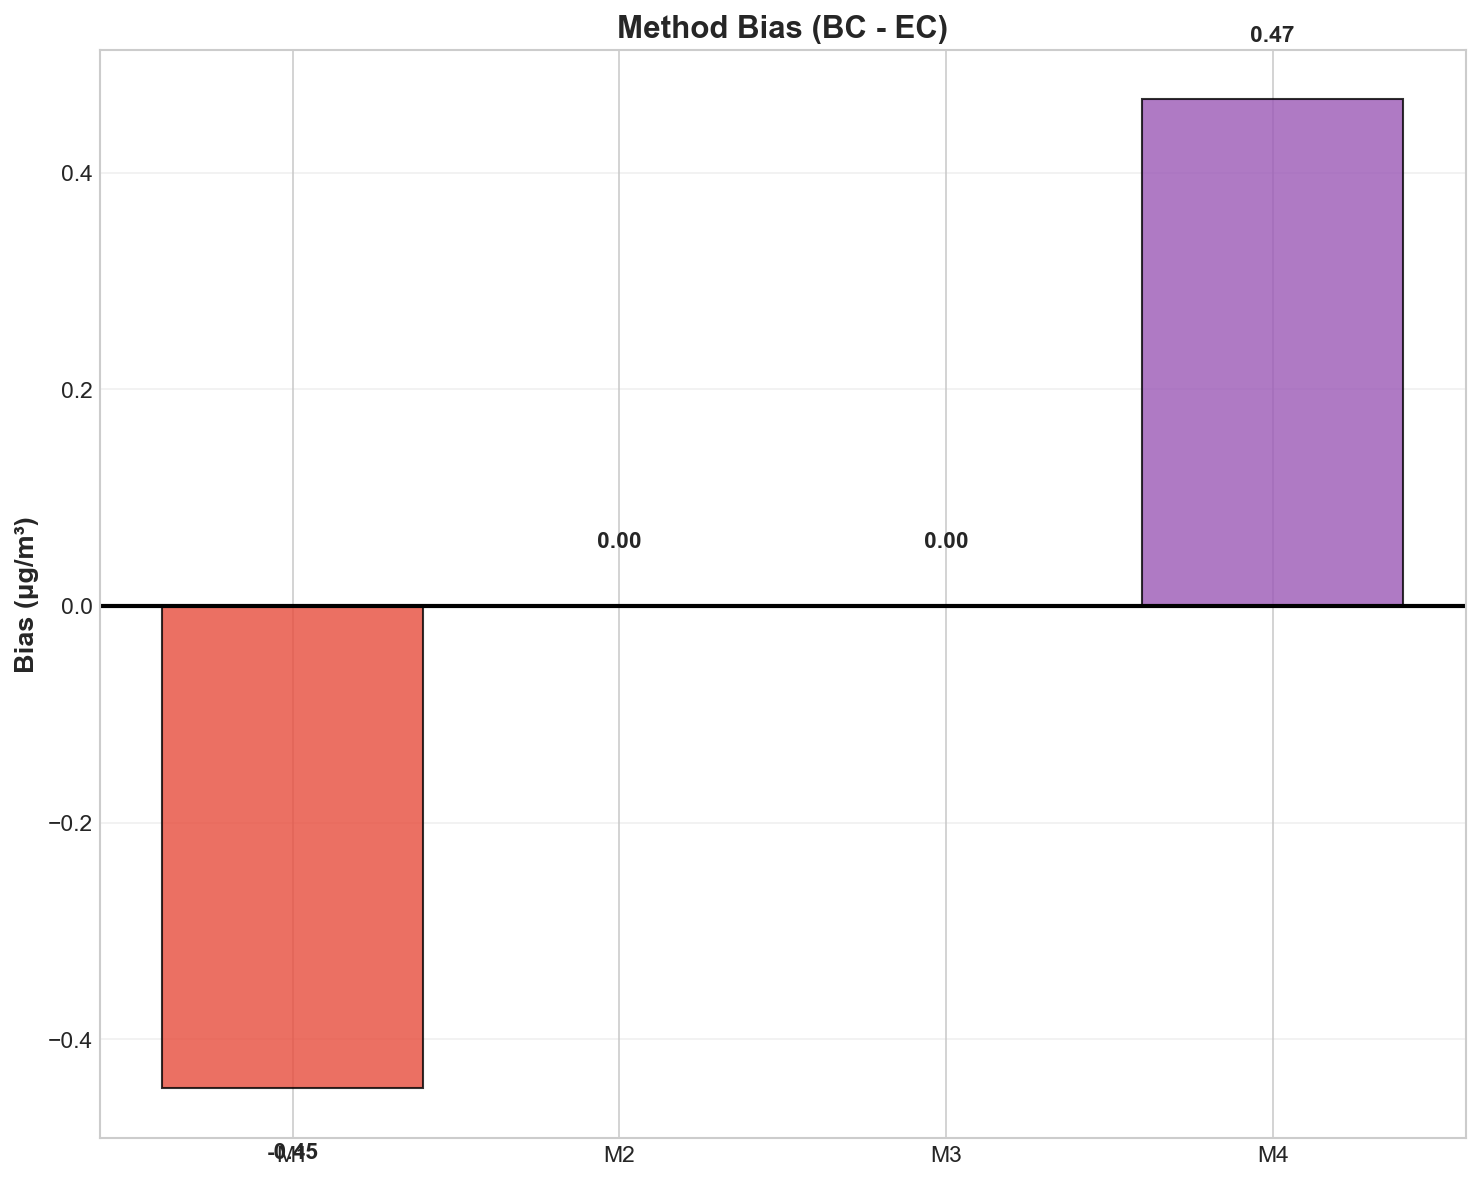

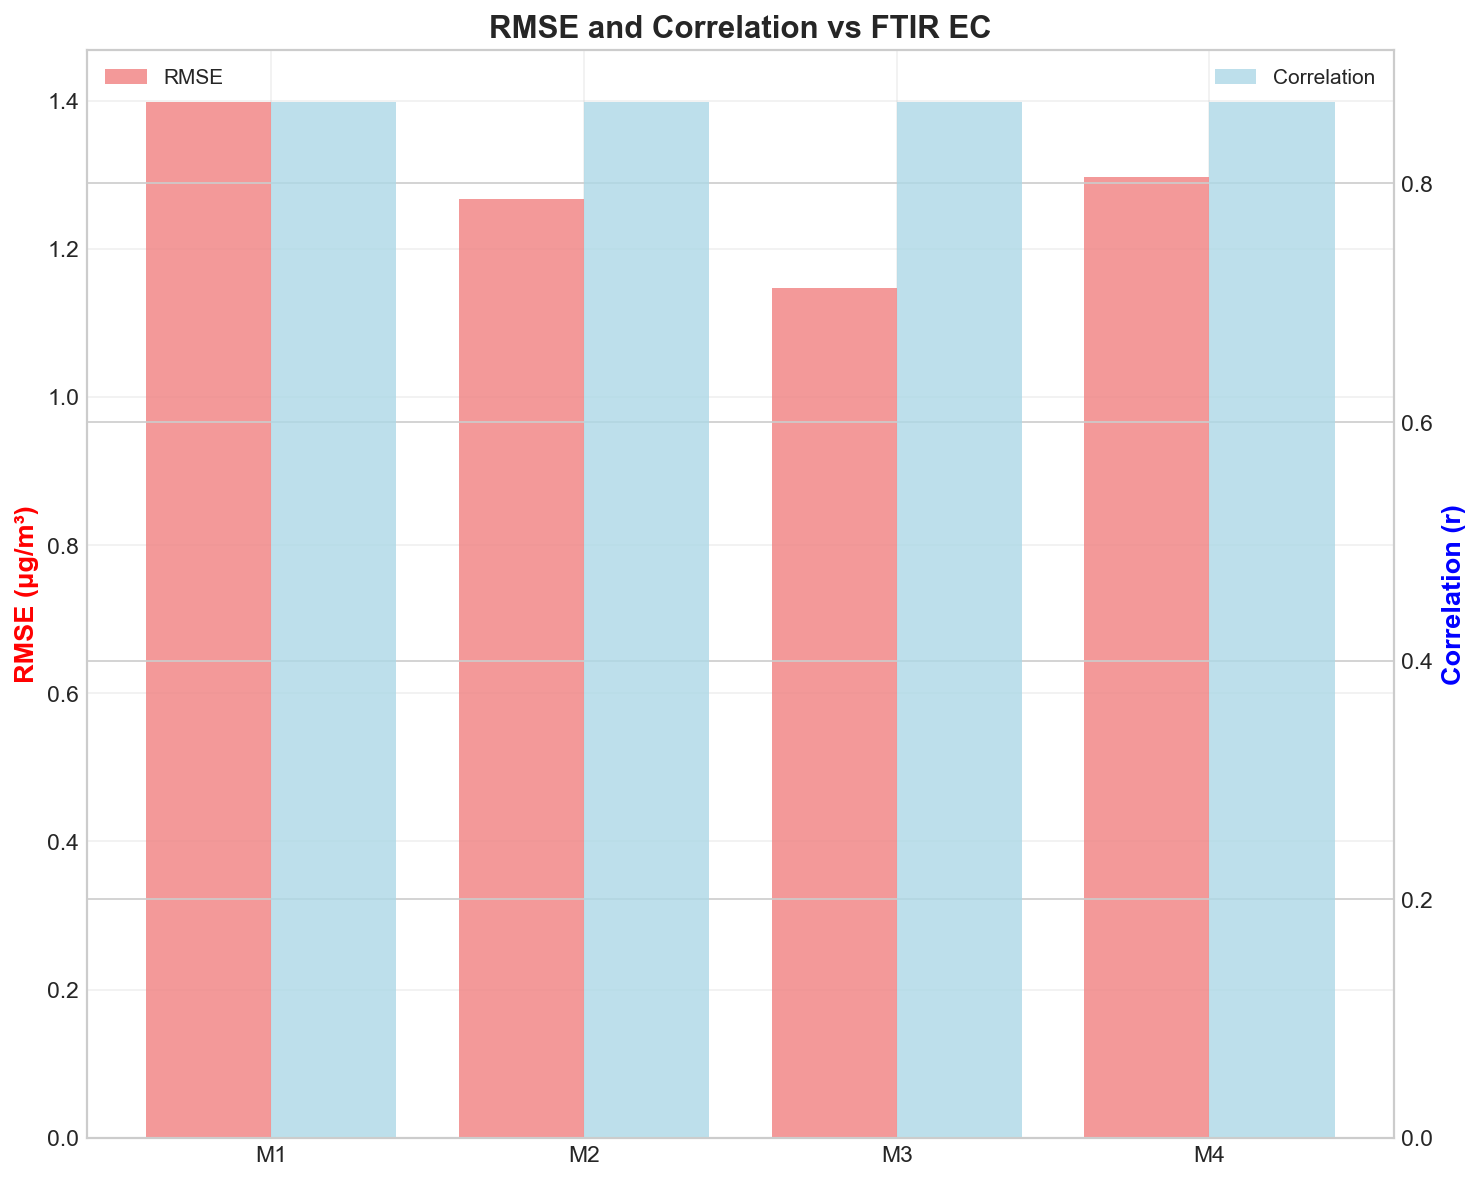

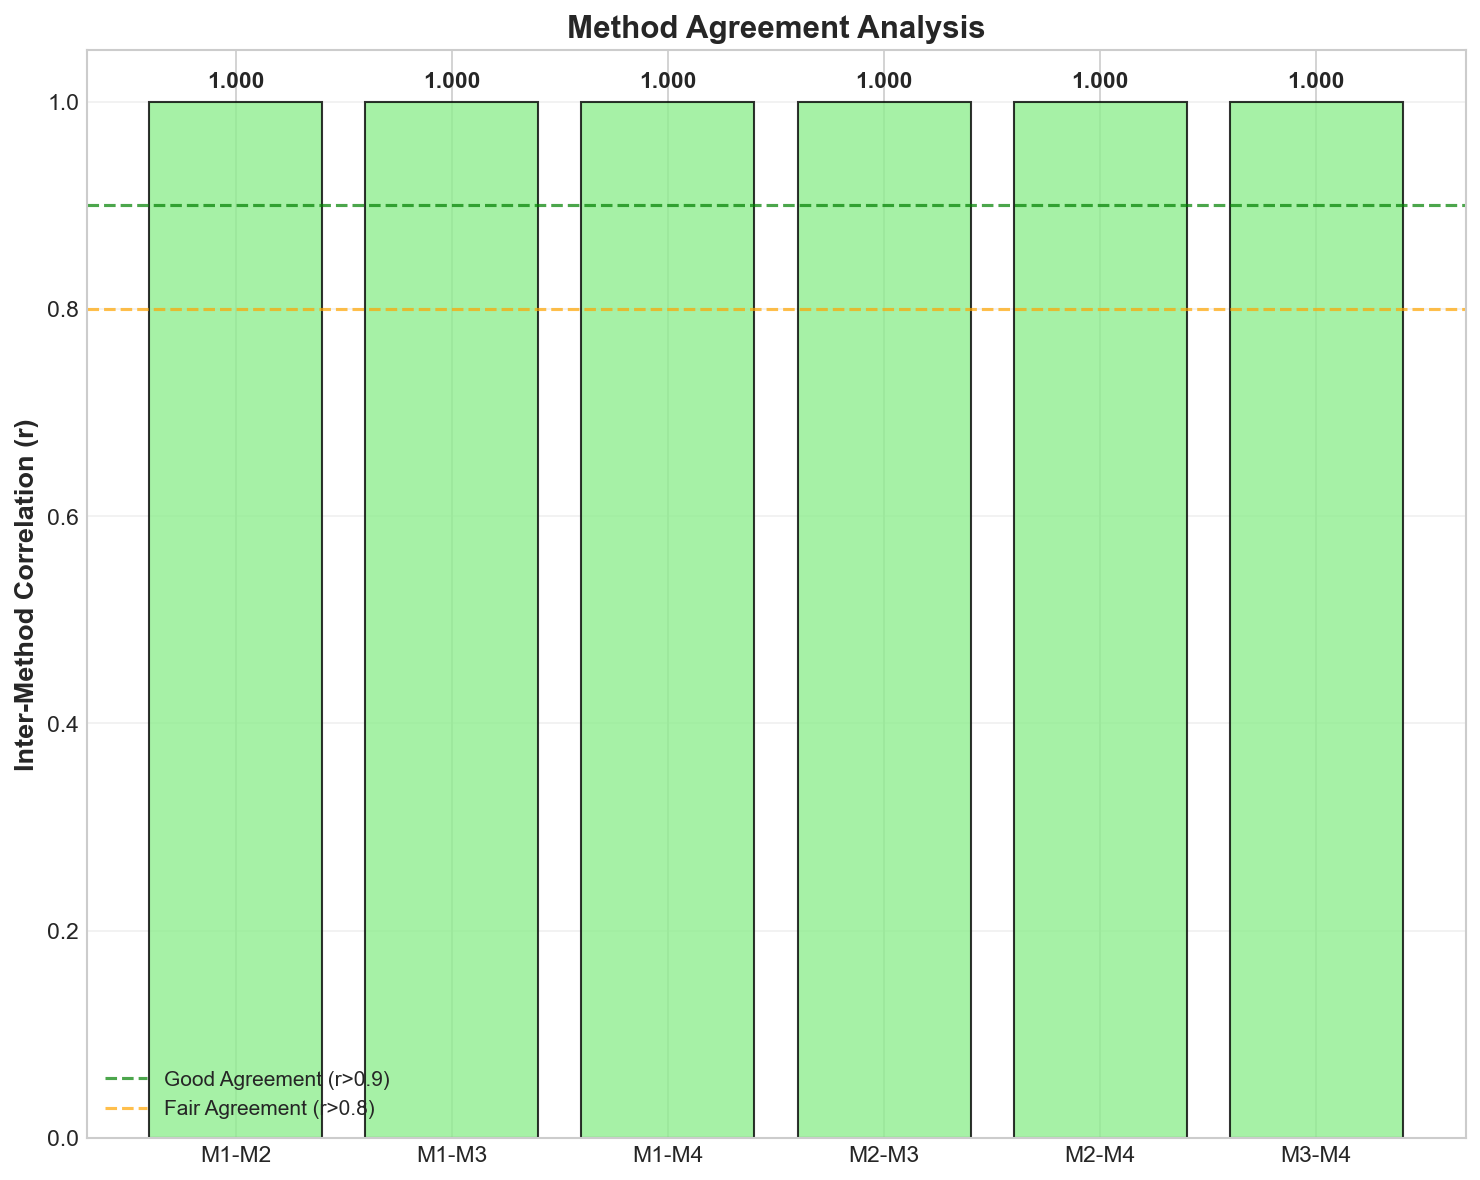

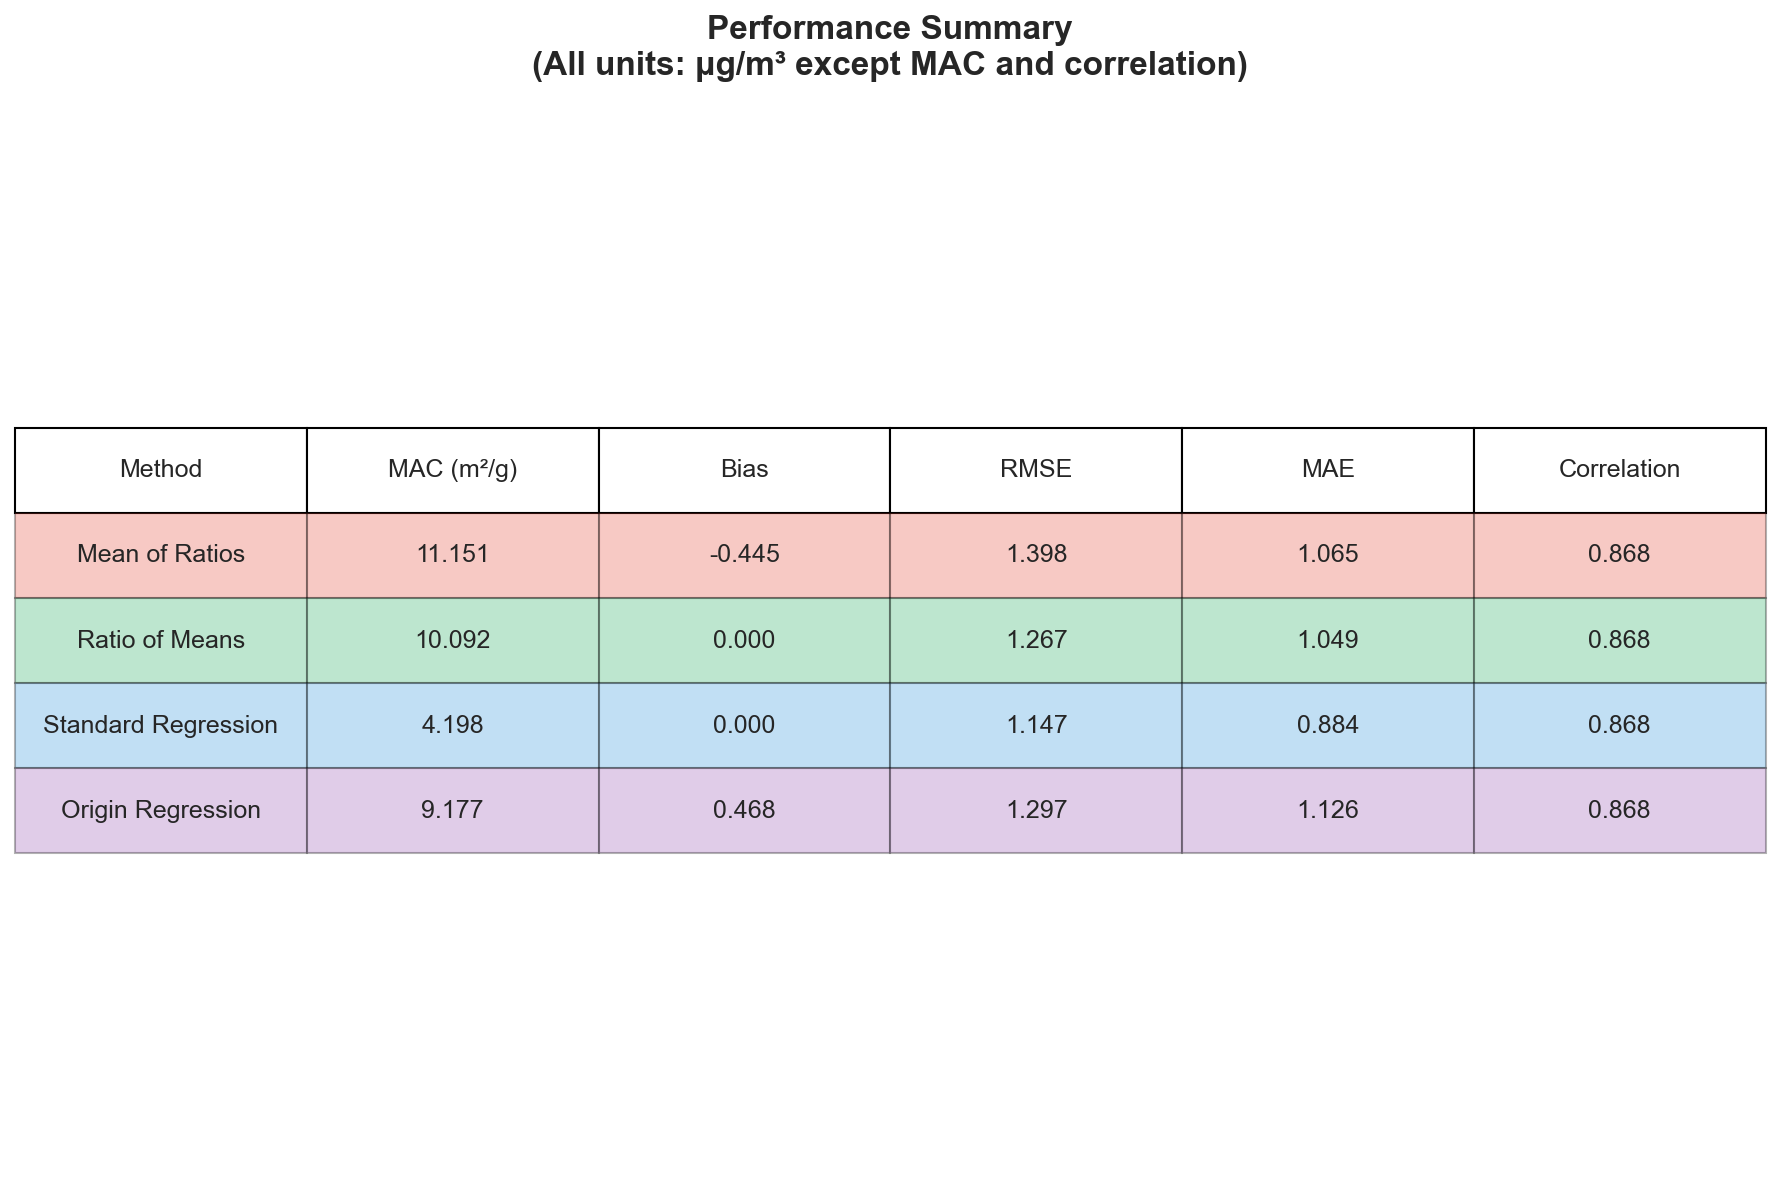


5. Creating MAC Methods Comparison...
📈 Creating MAC Methods Comparison (Individual Plots)...


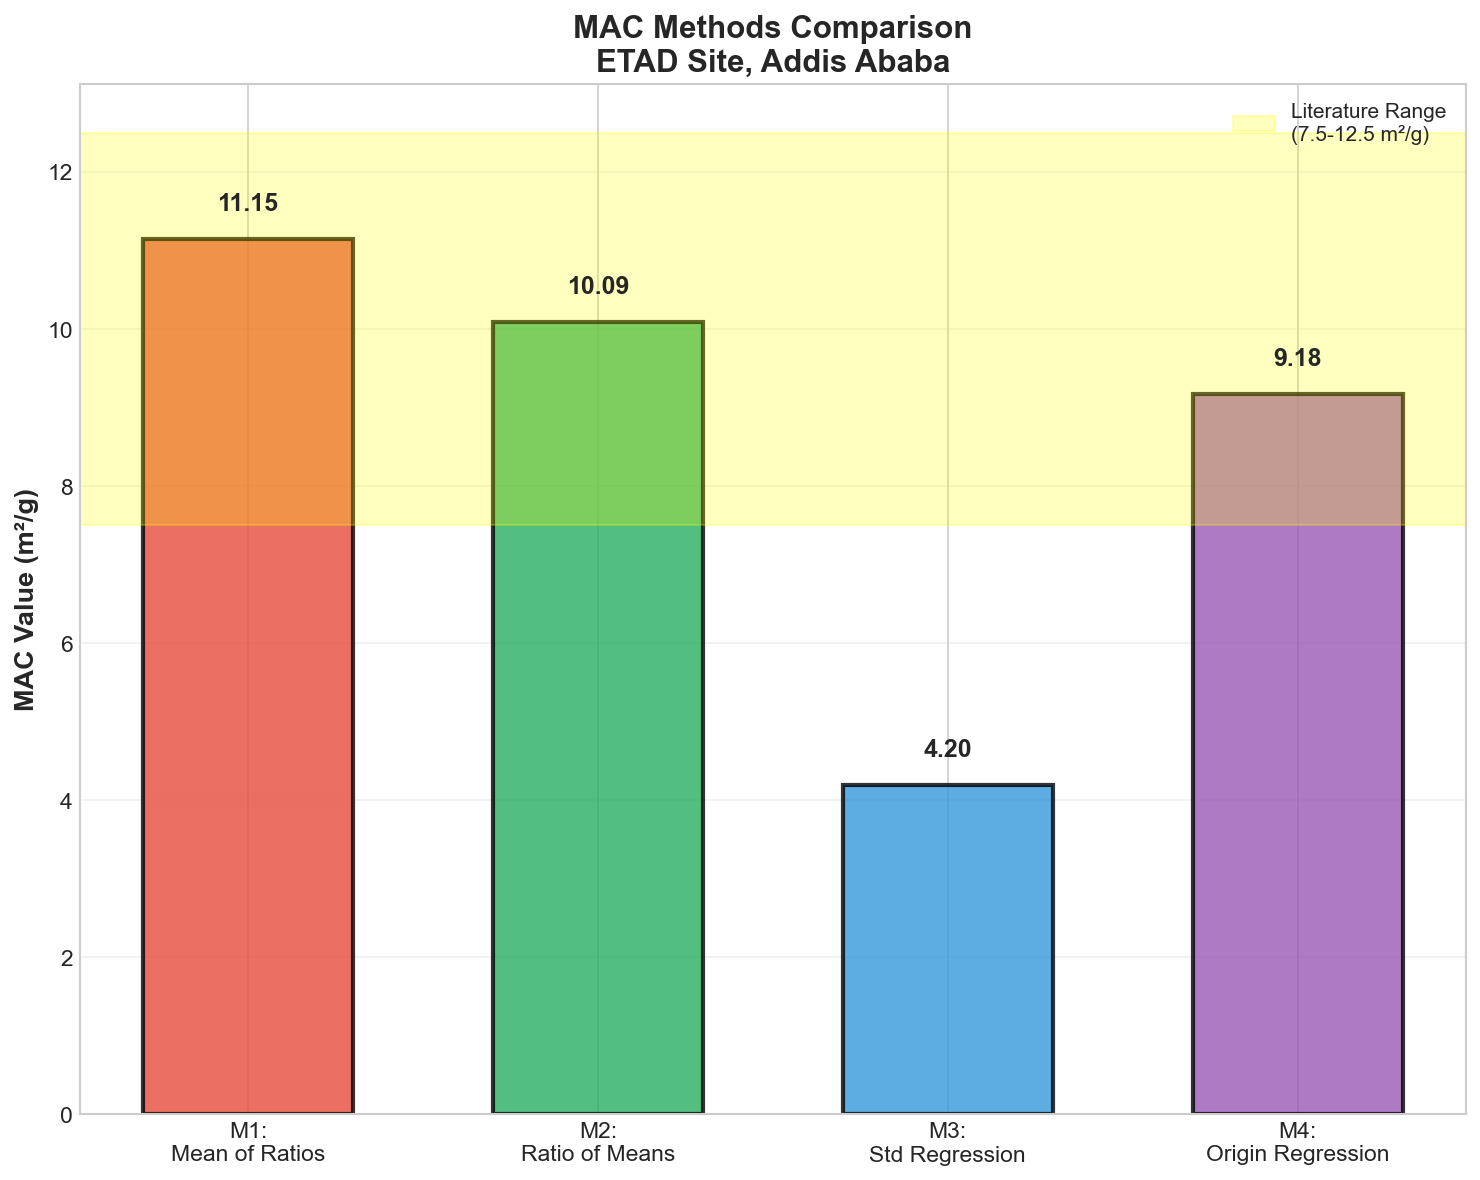

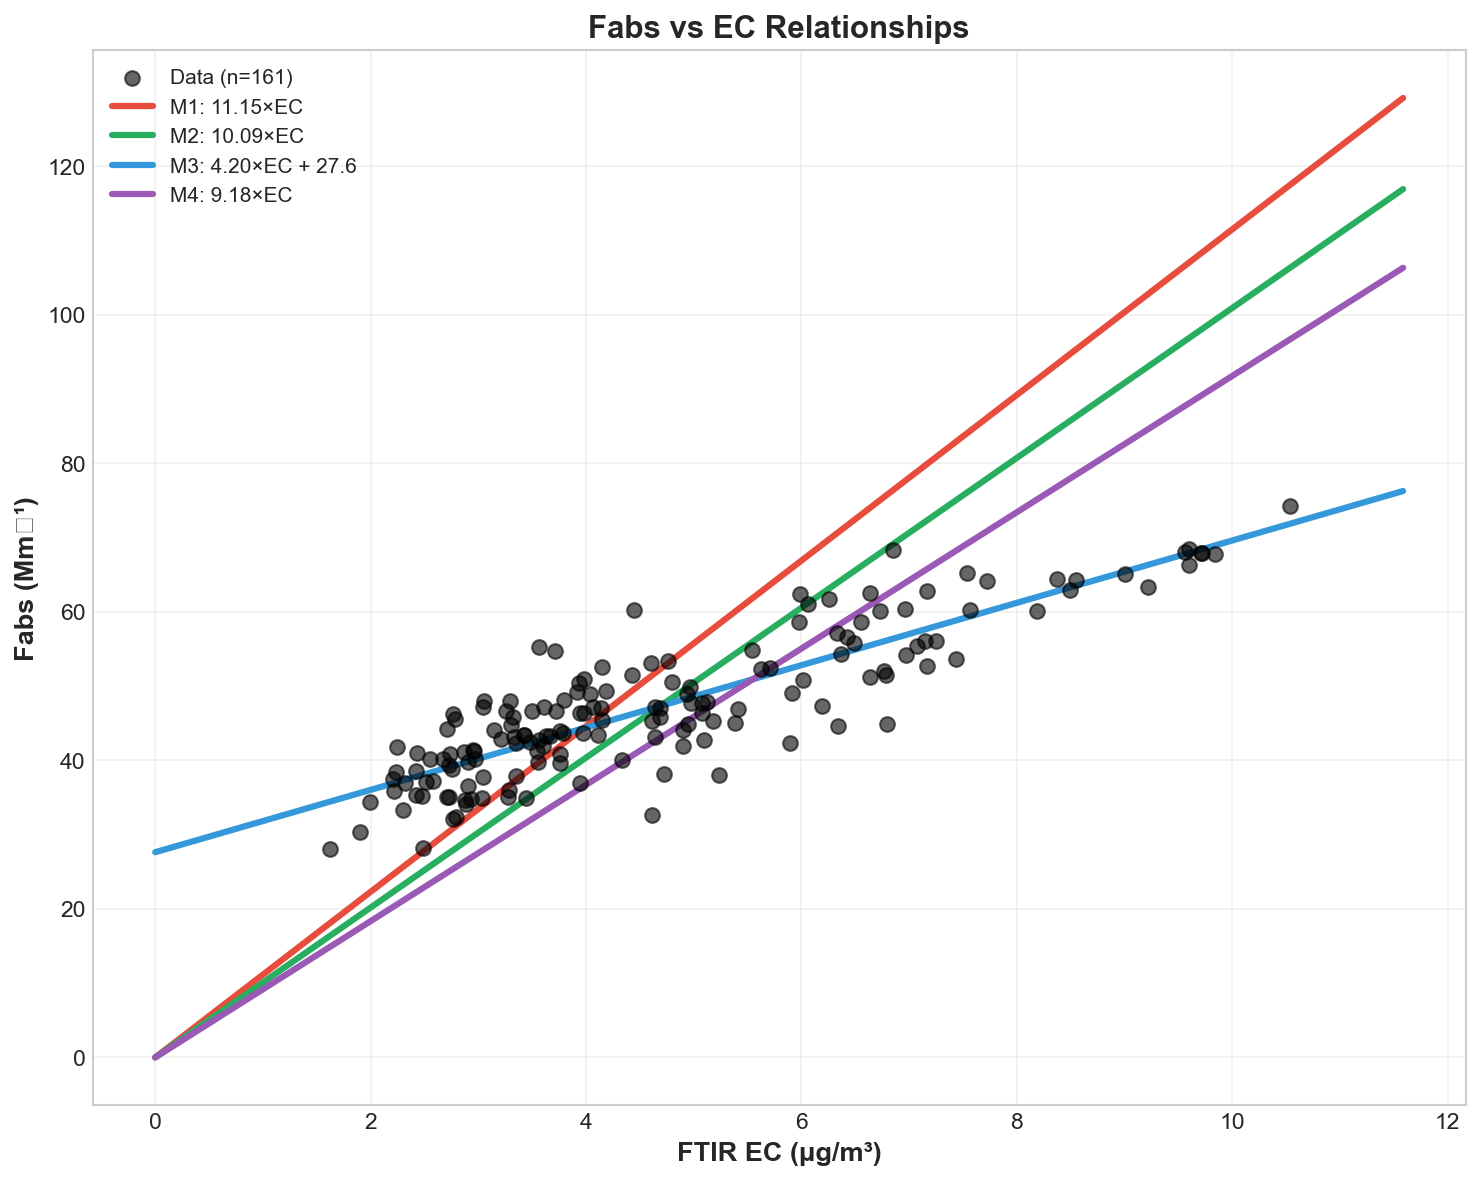

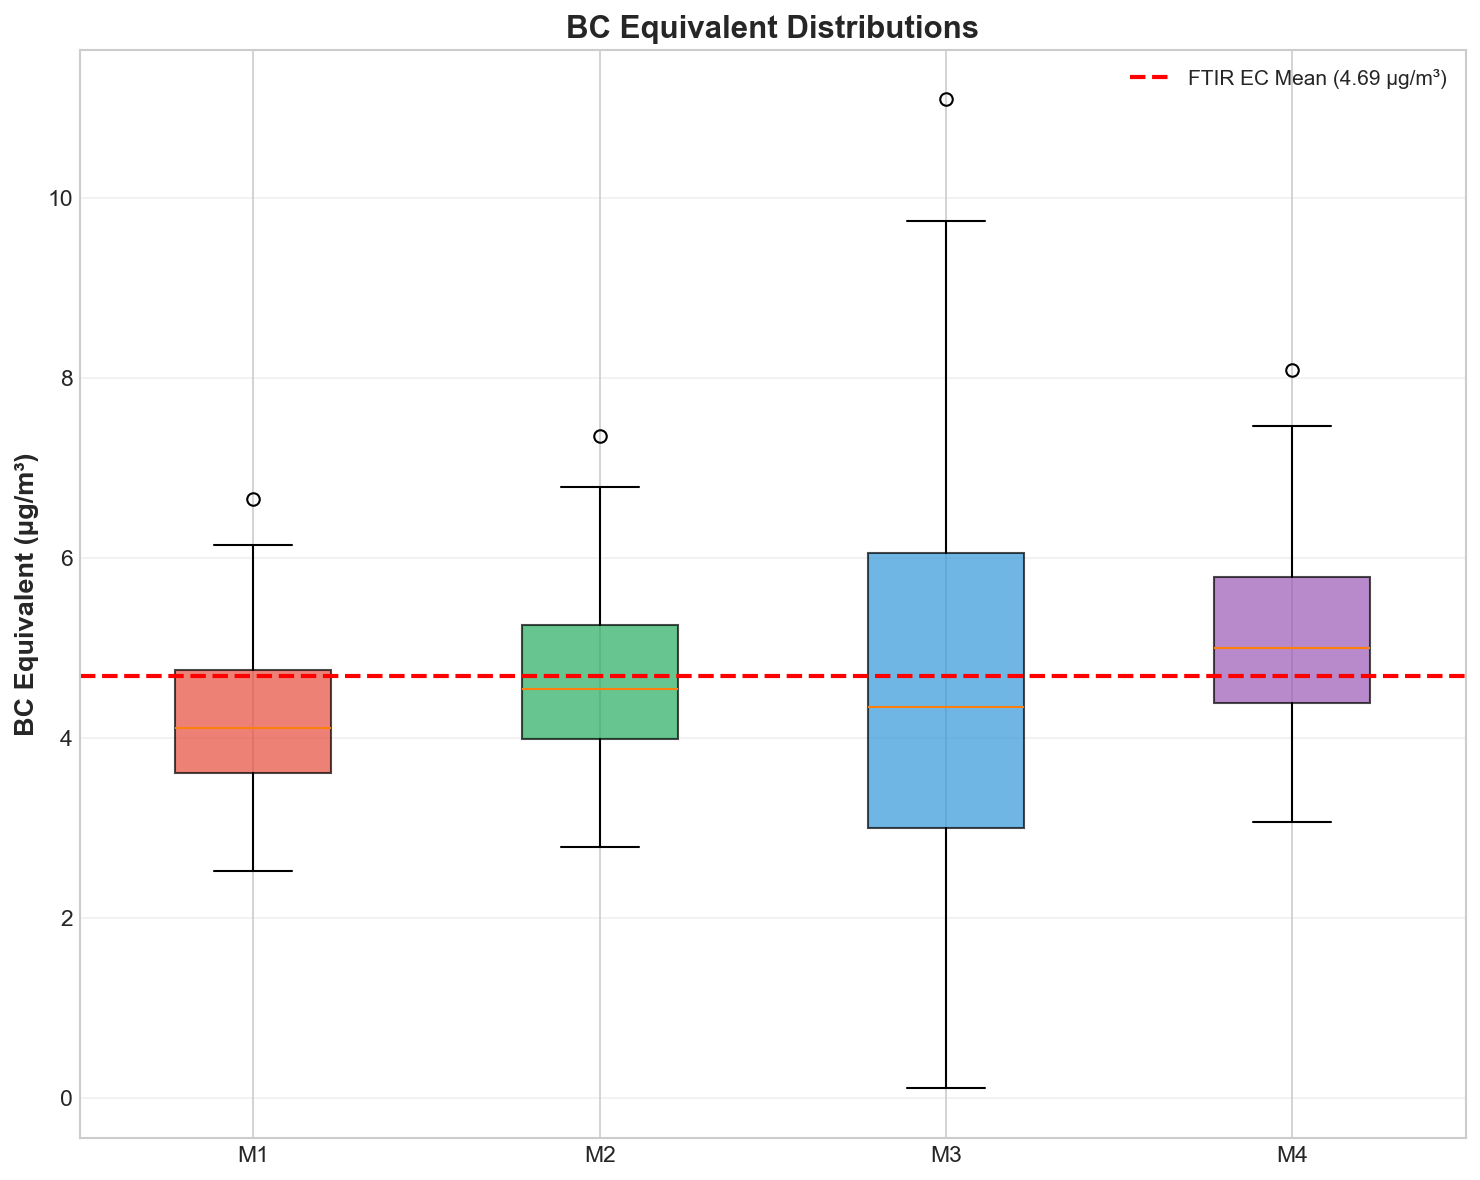

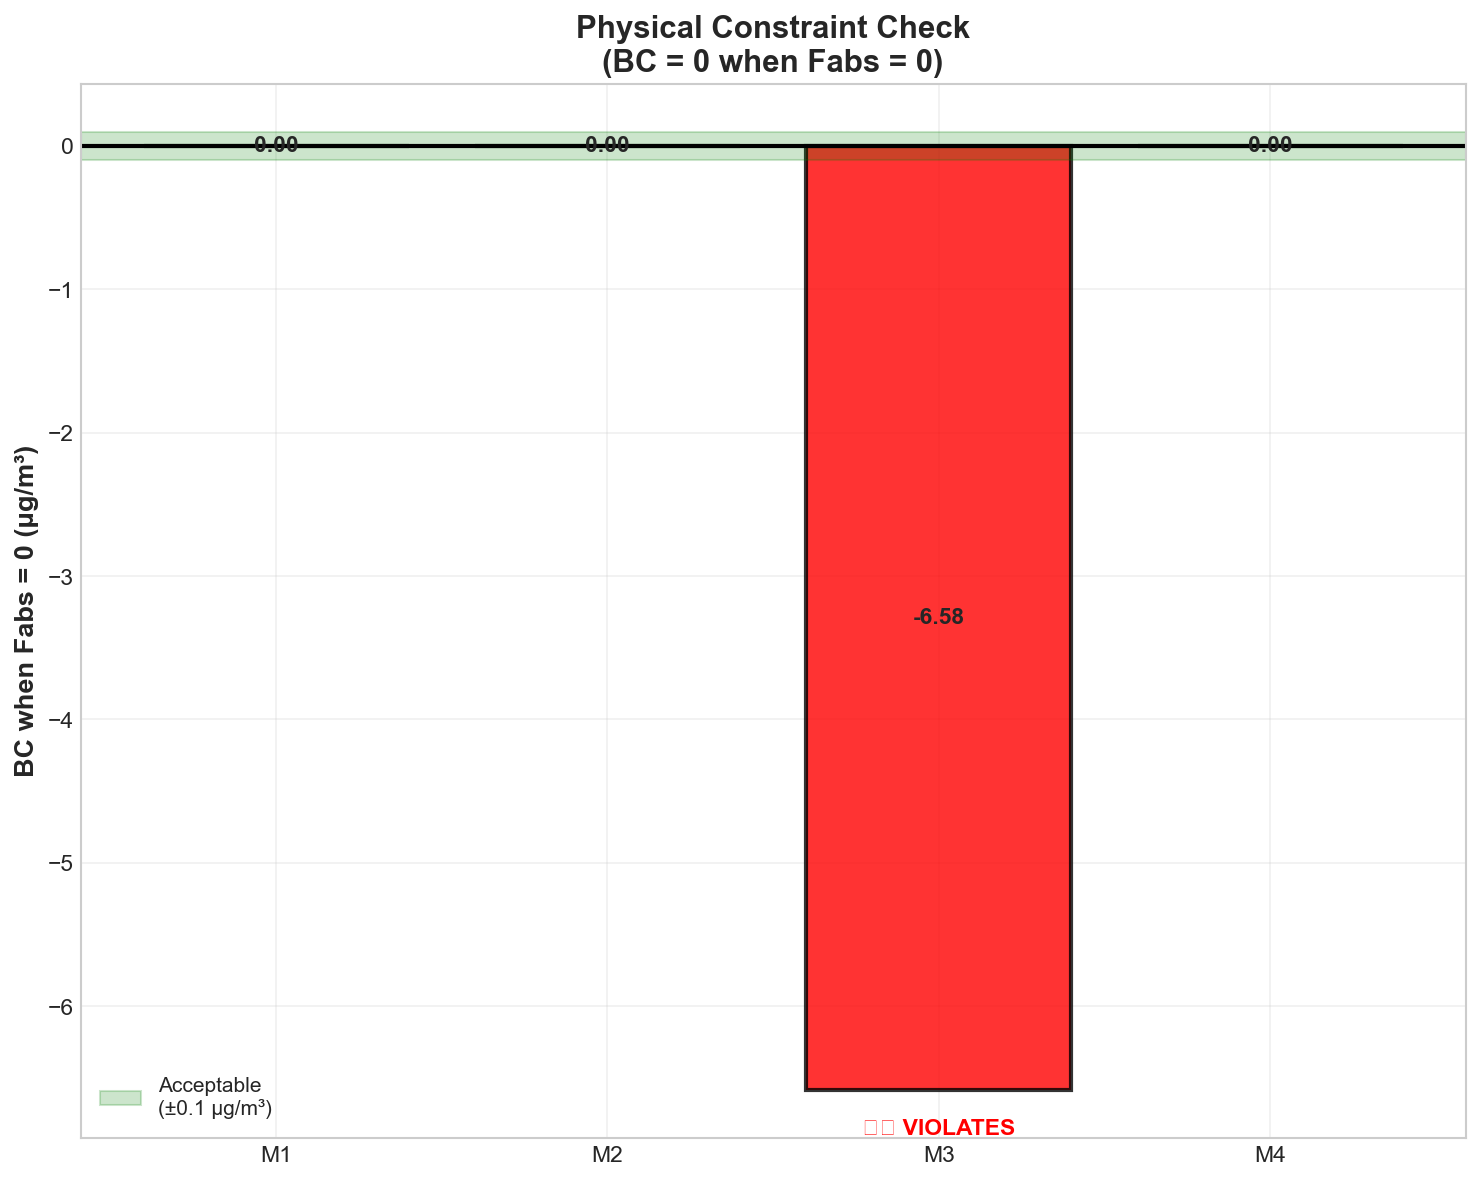


6. Analyzing Chemical Speciation Effects...
🧪 Creating Chemical Speciation Analysis (Individual Plots)...


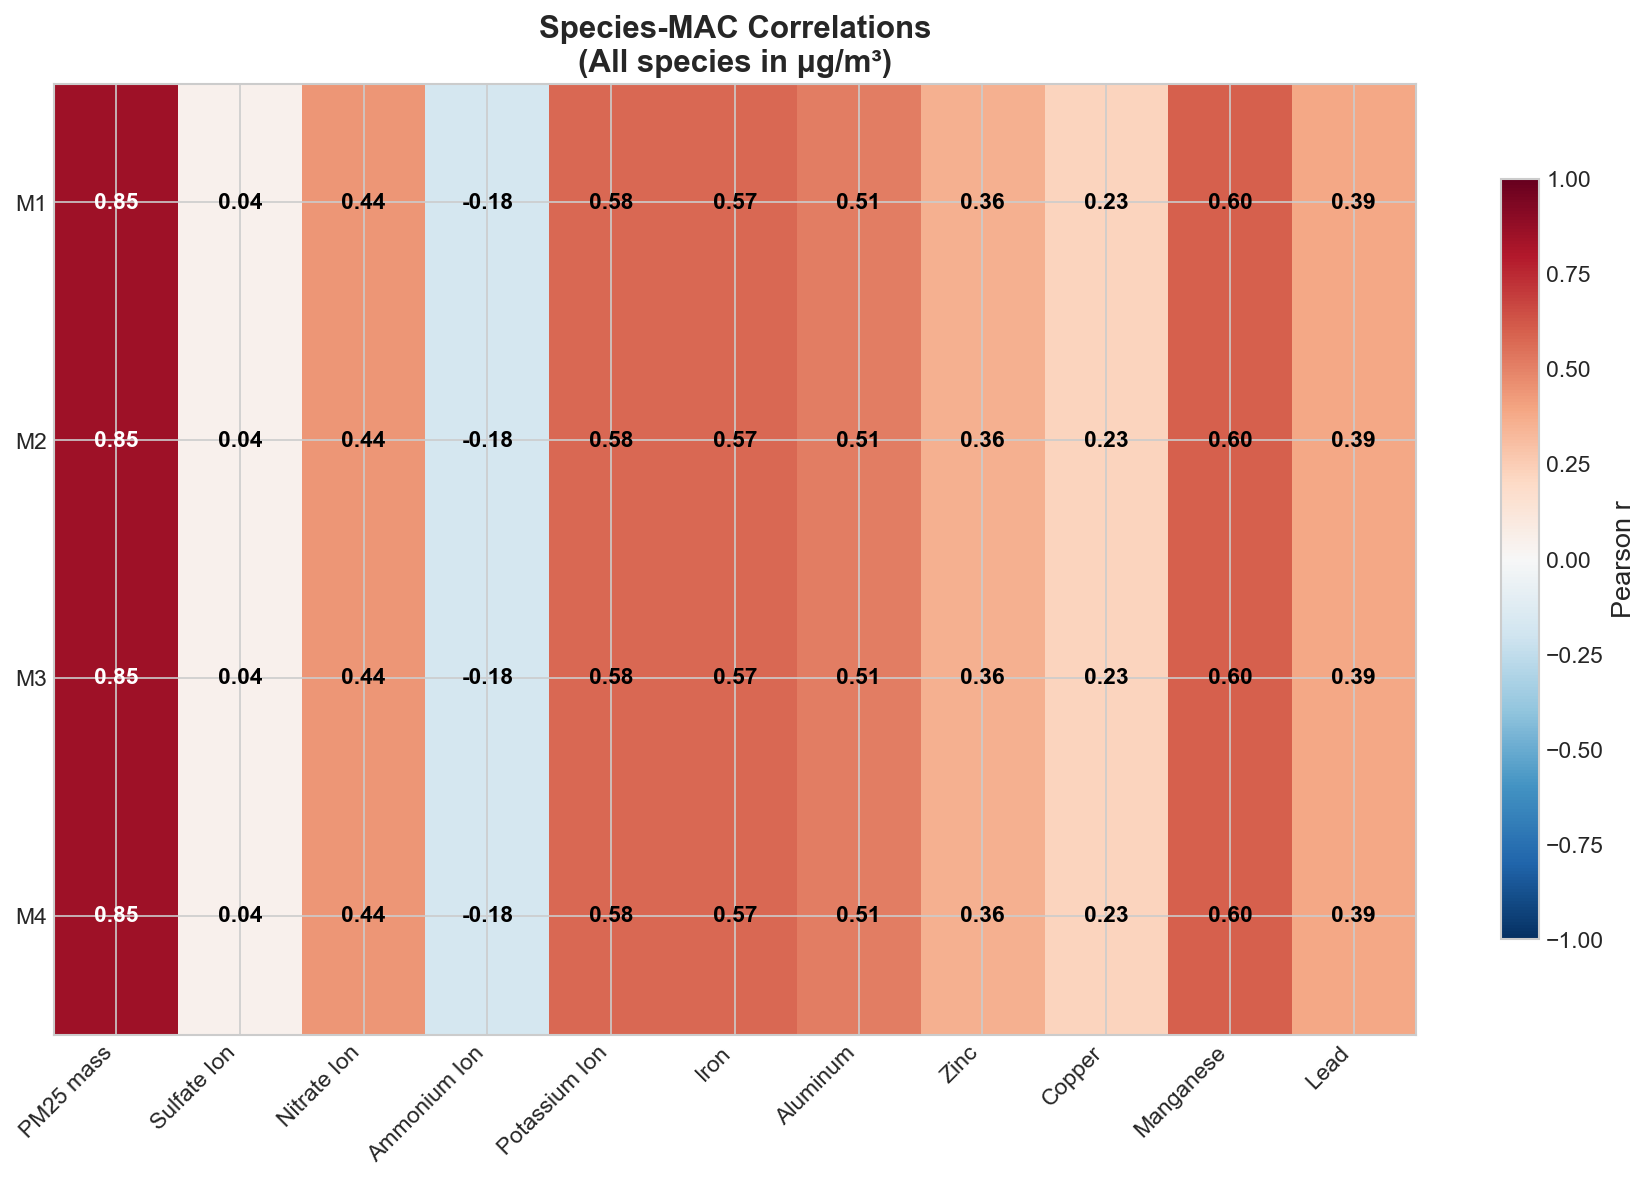

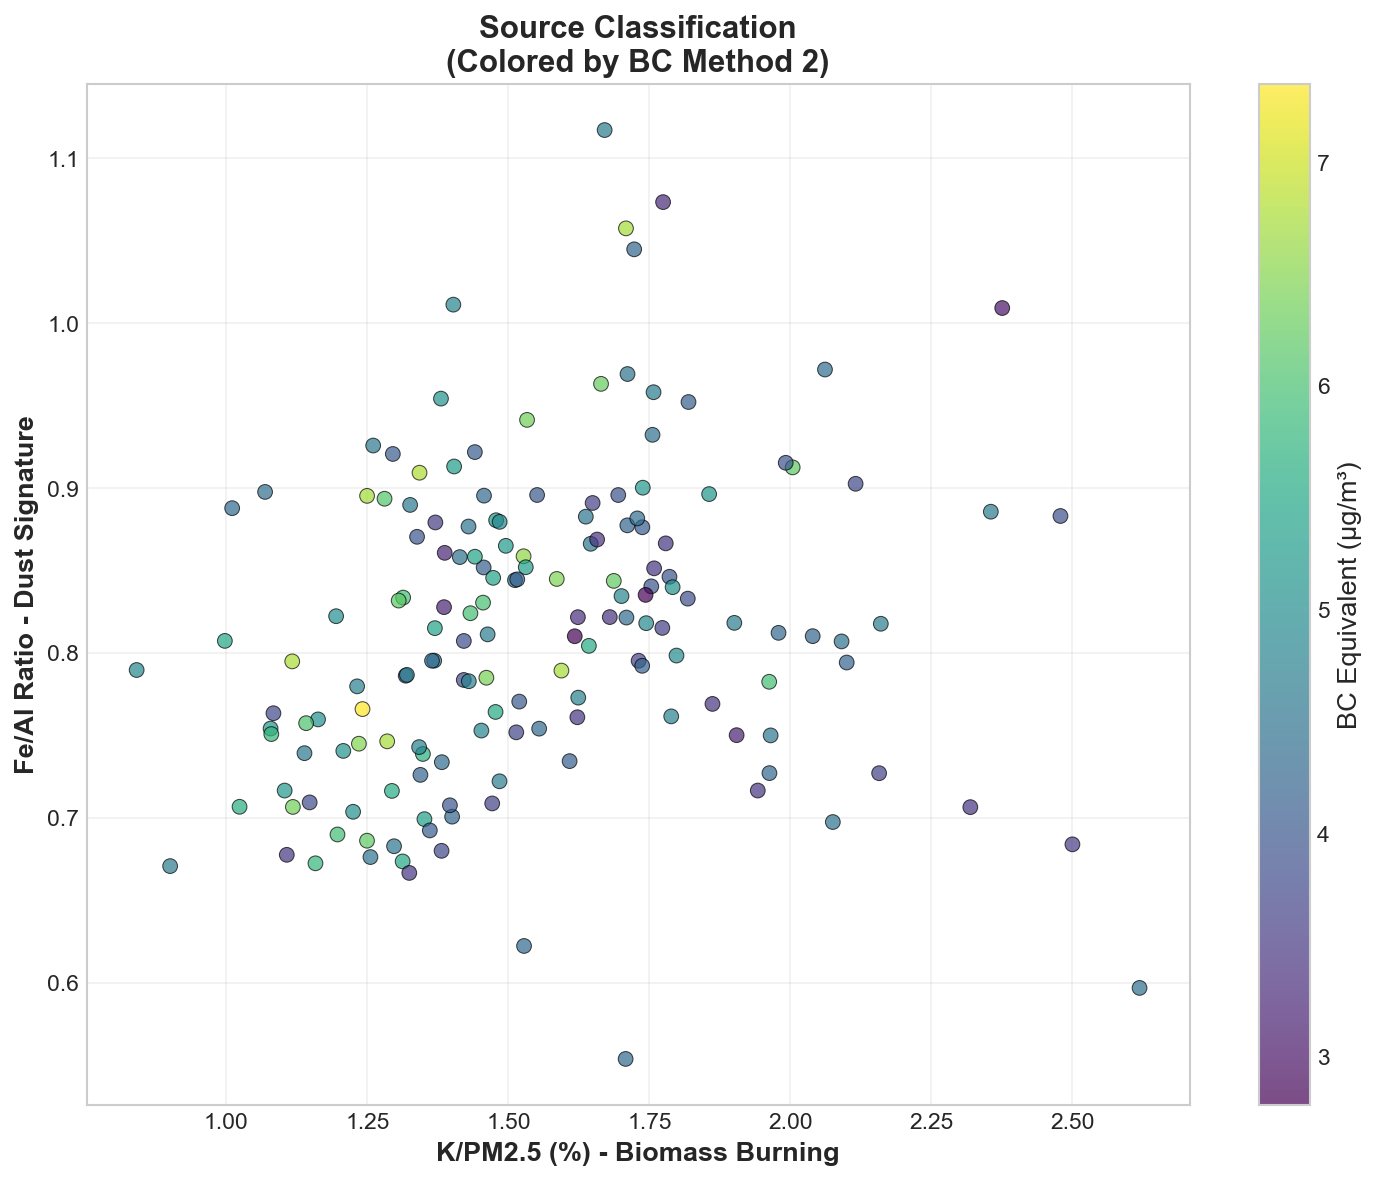

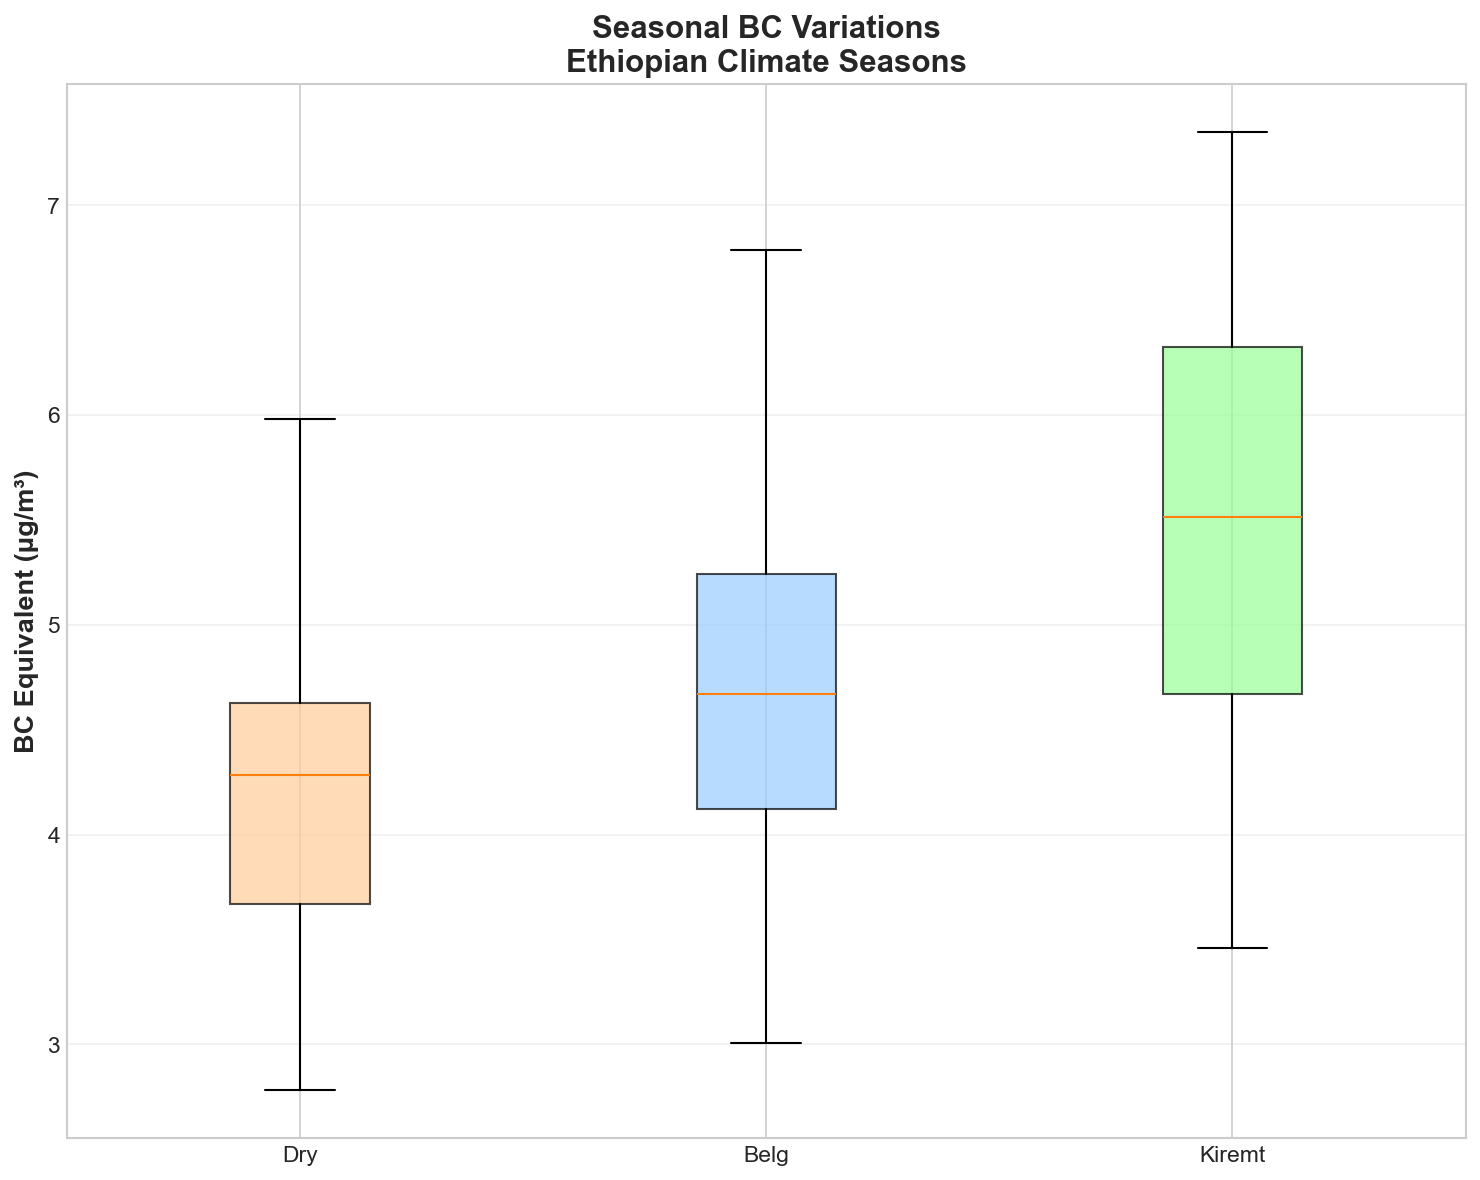

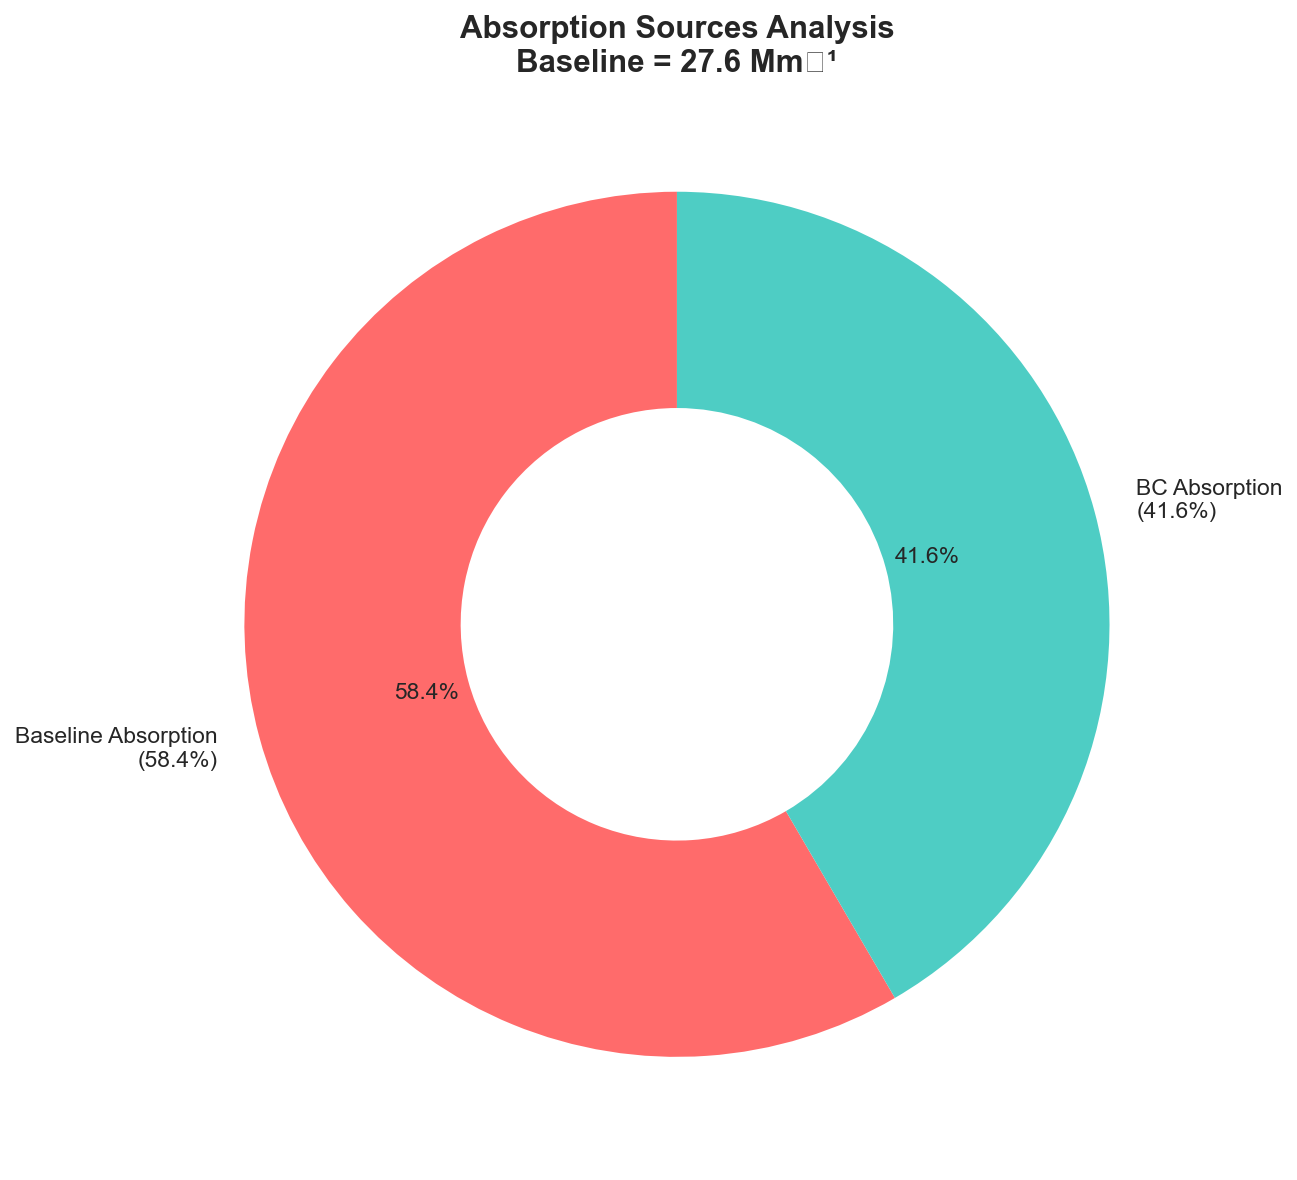


7. Analyzing Chemical Drivers...
🧪 Analyzing Chemical Drivers of MAC Variability (Individual Plots)...
Analyzing 161 samples with valid MAC values
MAC range: 6.60 - 18.65 m²/g
Chemical features for analysis: 16
Features: K_PM_ratio, Fe_Al_ratio, SO4_NO3_ratio, Potassium_Ion, Iron, Aluminum, Sulfate_Ion, Nitrate_Ion, Ammonium_Ion, PM25_mass, Zinc, Copper, Manganese, Lead, SIA_total, coating_thickness
Note: Excluded ec_ftir and fabs to avoid circular reasoning (MAC = fabs/ec_ftir)

🤖 RANDOM FOREST ANALYSIS RESULTS:
   Model R² Score: 0.962
   Top 5 Chemical Drivers of MAC Variability:
     10. PM25 mass: 0.298
     16. coating thickness: 0.178
     4. Potassium Ion: 0.158
     11. Zinc: 0.124
     8. Nitrate Ion: 0.043


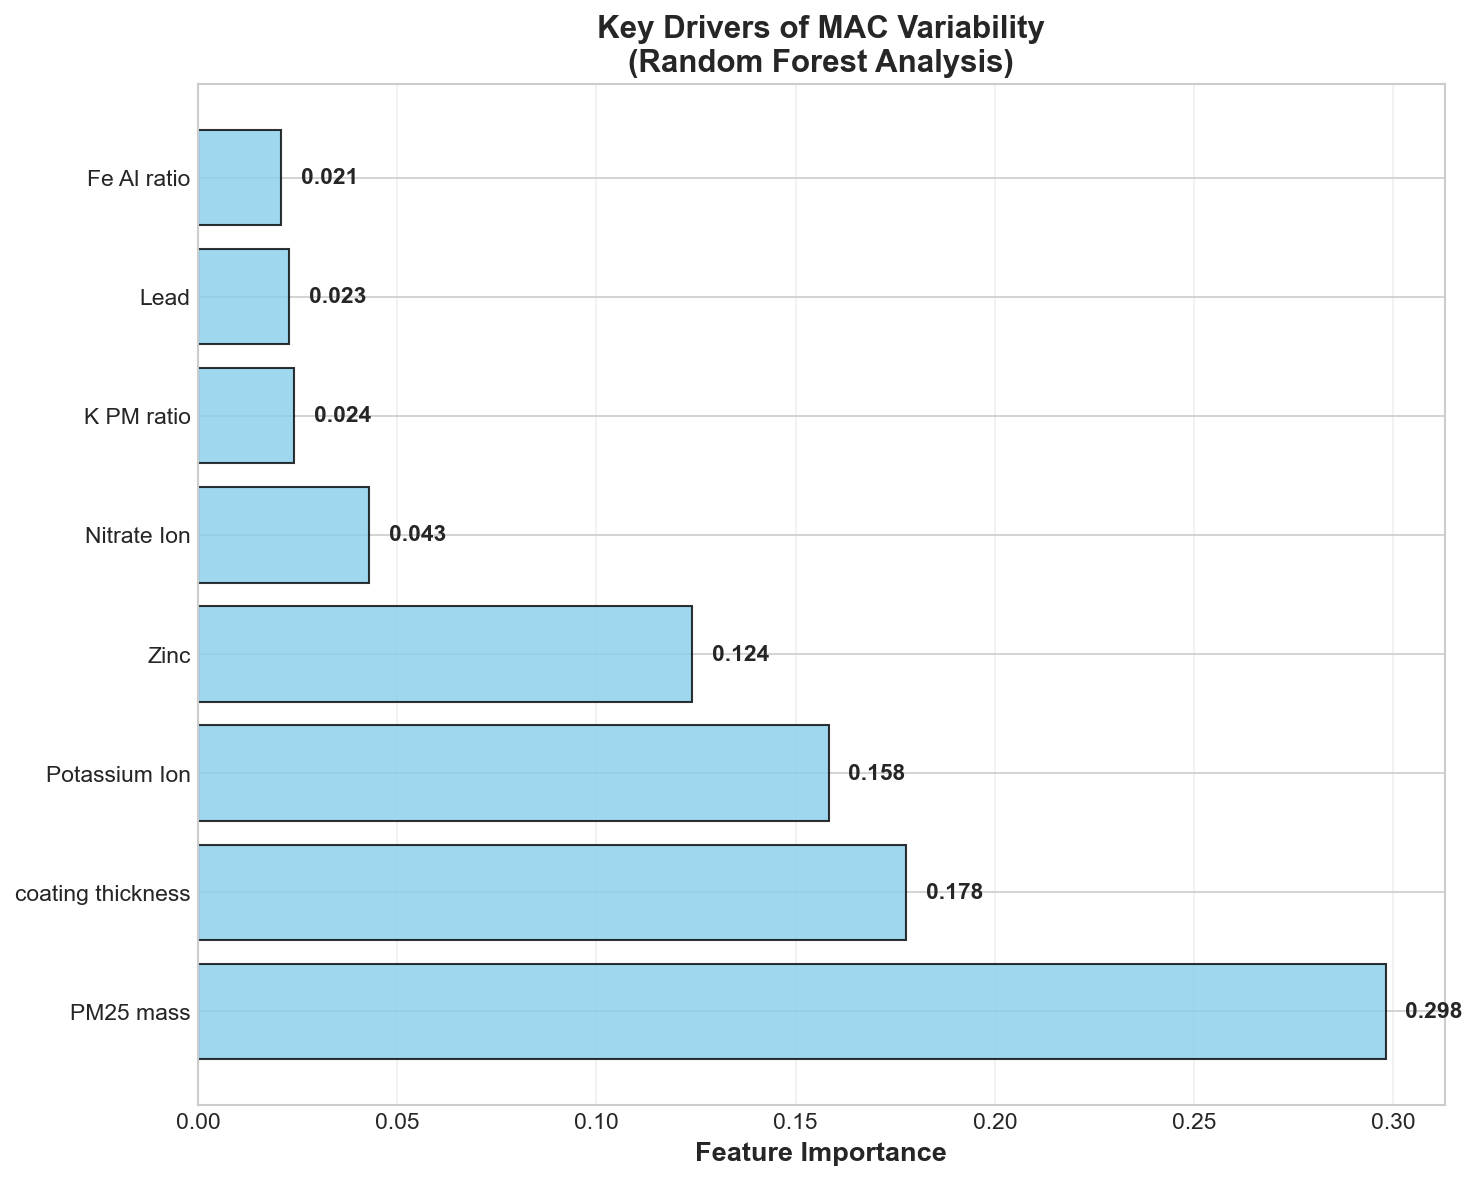

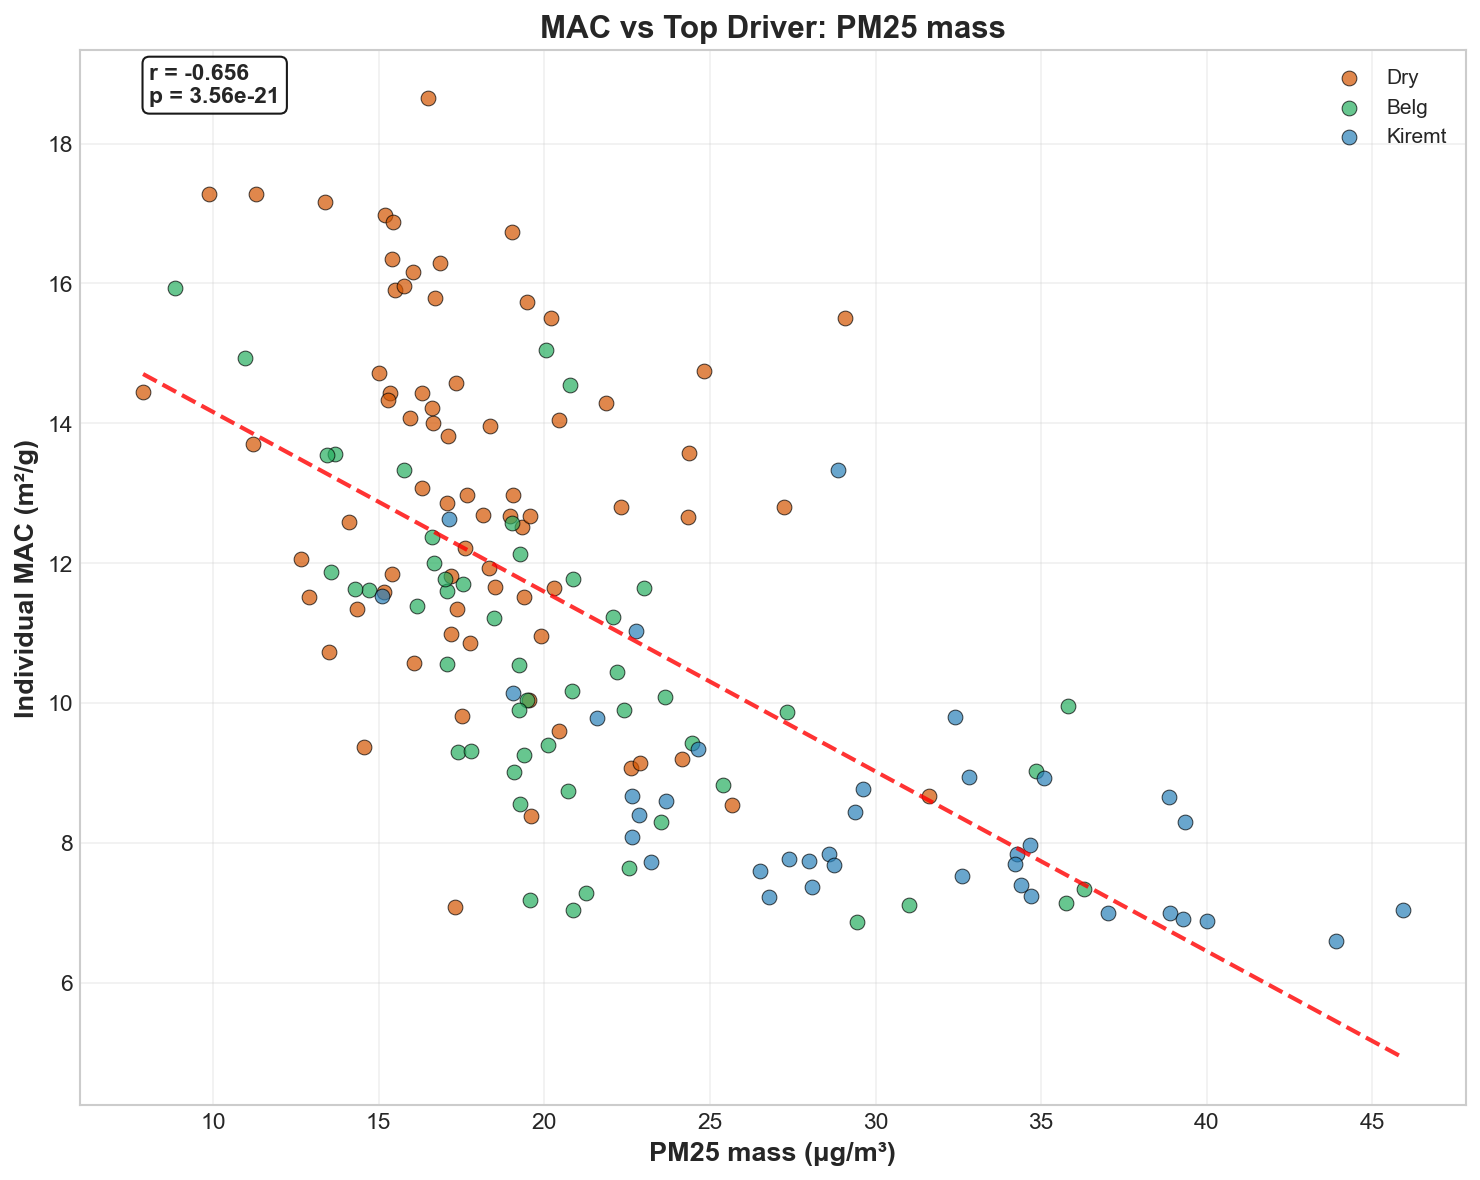

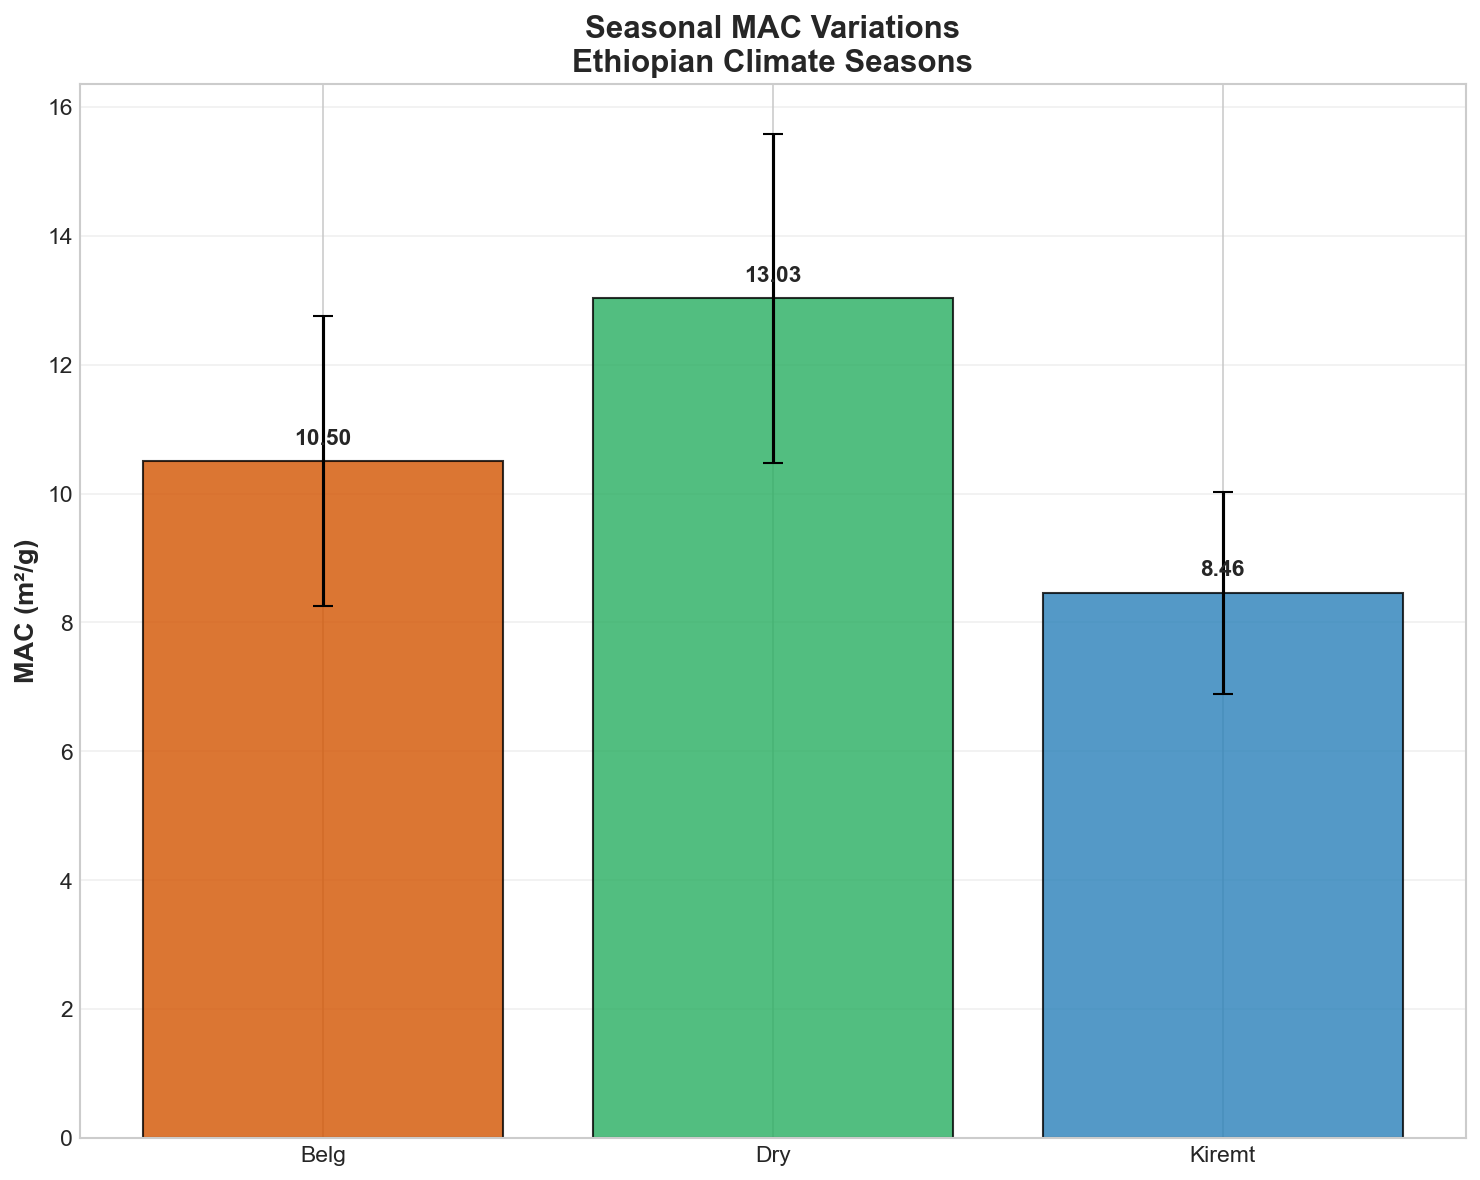

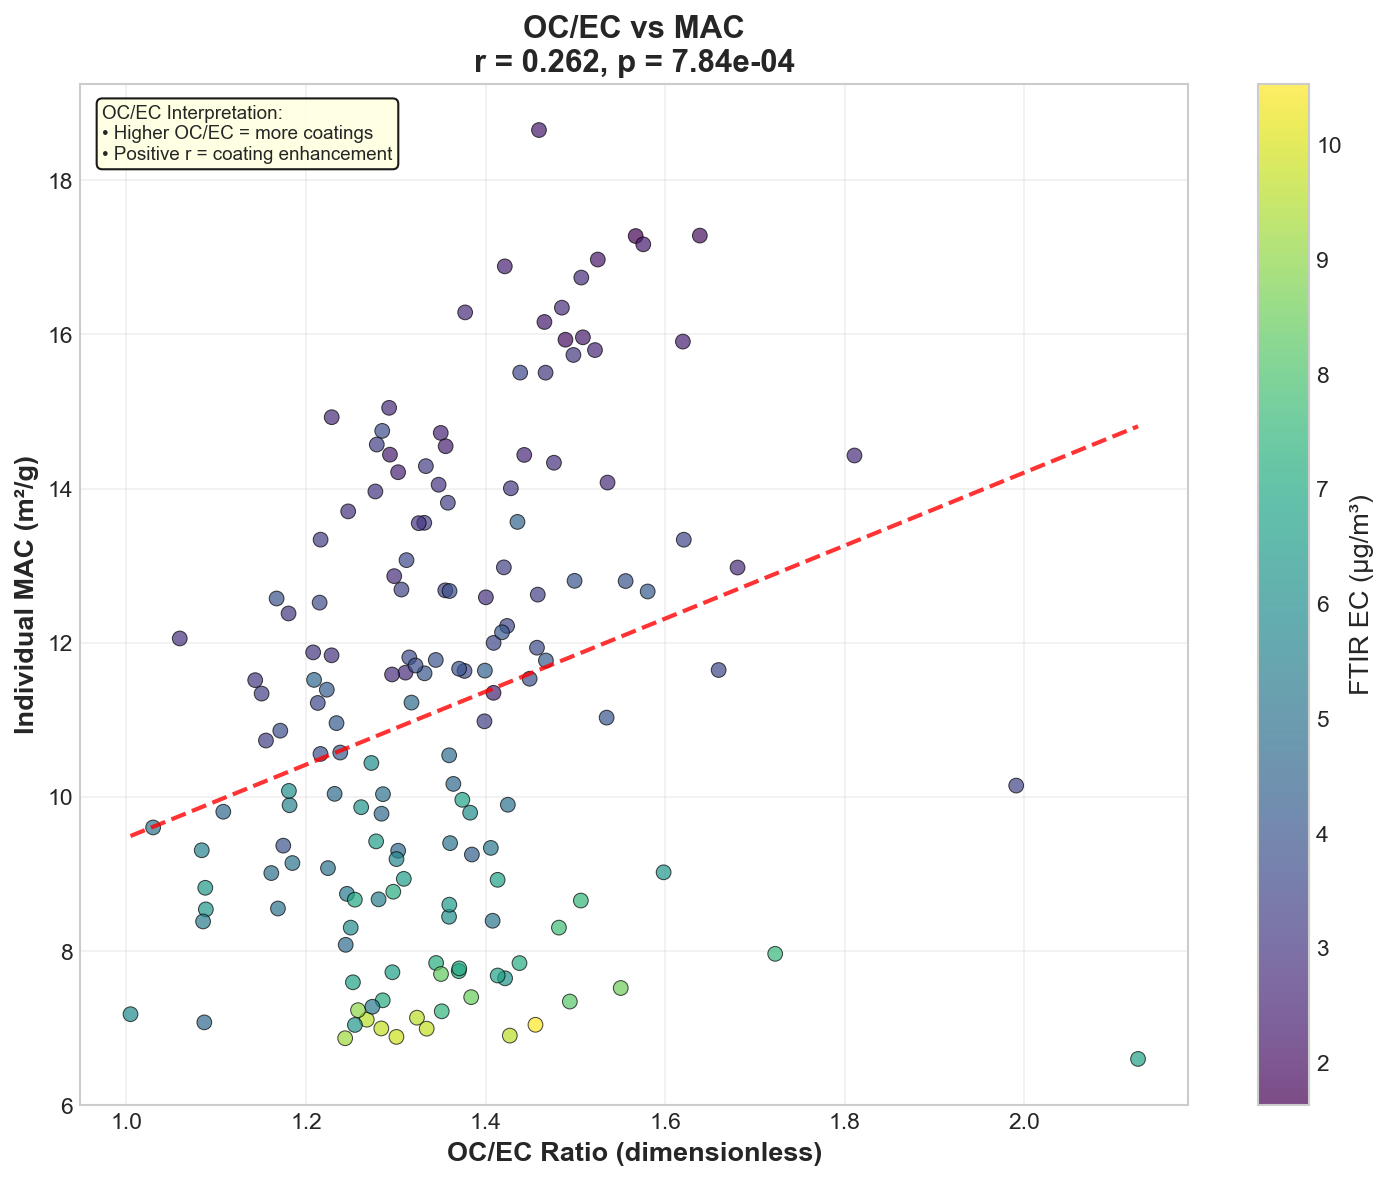


8. Creating Final Recommendations...
🎯 FINAL MAC METHOD RECOMMENDATIONS

📊 MAC METHOD RESULTS:
   Method 1 (Mean of Ratios):     11.15 m²/g
   Method 2 (Ratio of Means):     10.09 m²/g
   Method 3 (Standard Regression): 4.20 m²/g + 27.6 Mm⁻¹
   Method 4 (Origin Regression):   9.18 m²/g

🥇 RECOMMENDED METHOD: Standard Regression
   MAC Value: 4.20 m²/g
   Performance Metrics:
     • Bias: 0.000 μg/m³
     • RMSE: 1.147 μg/m³
     • Correlation: 0.868

✅ JUSTIFICATION:
   • Note: Has baseline absorption of 27.6 Mm⁻¹
   • Uses regression approach
   • MAC value within reasonable range for African urban environment
   • Best overall statistical performance

⚠️ METHOD-SPECIFIC CONSIDERATIONS:

Method 3 (Standard Regression):
   • Large intercept (27.6 Mm⁻¹) violates BC = 0 when Fabs = 0
   • May represent real brown carbon baseline absorption
   • Use only if non-BC absorption is confirmed and accounted for

🌍 ADDIS ABABA ATMOSPHERIC CONTEXT:
   • High baseline absorption indicates brown c

In [10]:
def run_complete_etad_analysis(db_path, csv_path):
    """Run the complete ETAD MAC-speciation analysis"""
    
    print("🚀 COMPLETE ETAD MAC-SPECIATION ANALYSIS")
    print("="*80)
    
    # Step 1: Load data
    print("\n1. Loading Data...")
    ftir_data = load_etad_ftir_data(db_path)
    if ftir_data is None:
        return None
    
    spec_data = load_etad_speciation_data(csv_path)
    if spec_data is None:
        return None
    
    # Step 2: Merge datasets
    print("\n2. Merging Datasets...")
    merged_data = merge_etad_datasets(ftir_data, spec_data)
    if merged_data is None:
        return None
    
    # Step 3: Calculate MAC methods
    print("\n3. Calculating MAC Methods...")
    mac_results = calculate_mac_methods(merged_data)
    
    # Step 4: Performance analysis
    print("\n4. Analyzing Method Performance...")
    performance_metrics = analyze_method_performance(merged_data, mac_results)
    
    # Step 5: Create visualizations
    print("\n5. Creating MAC Methods Comparison...")
    create_mac_methods_comparison(merged_data, mac_results)
    
    print("\n6. Analyzing Chemical Speciation Effects...")
    correlations = create_chemical_speciation_analysis(merged_data, mac_results)
    
    # Step 6: Chemical drivers analysis
    print("\n7. Analyzing Chemical Drivers...")
    feature_importance, mac_clean = analyze_chemical_drivers_of_mac(merged_data)
    
    # Step 7: Final recommendations
    print("\n8. Creating Final Recommendations...")
    create_final_recommendations(mac_results, performance_metrics, feature_importance)

    
    print("\n✅ COMPLETE ANALYSIS FINISHED!")
    print(f"\n📊 Analysis Summary:")
    print(f"   • FTIR samples: {len(ftir_data)}")
    print(f"   • Speciation samples: {len(spec_data)}")
    print(f"   • Merged samples: {len(merged_data)}")
    print(f"   • MAC methods calculated: 4")
    print(f"   • Chemical species analyzed: {len([col for col in merged_data.columns if col in ['PM25_mass', 'Sulfate_Ion', 'Nitrate_Ion', 'Potassium_Ion', 'Iron', 'Aluminum']])}")
    
    return {
        'ftir_data': ftir_data,
        'speciation_data': spec_data,
        'merged_data': merged_data,
        'mac_results': mac_results,
        'performance_metrics': performance_metrics,
        'correlations': correlations,
        'feature_importance': feature_importance,
        'mac_clean': mac_clean
    }

# Example usage:
if __name__ == "__main__":
    # Set your file paths
    DB_PATH = "/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/EC-HIPS-Aeth Comparison/Data/Original Data/Combined Database/spartan_ftir_hips.db"
    CSV_PATH = "/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/EC-HIPS-Aeth Comparison/Data/Downloaded Data/SPARTAN/Addis Ababa/FilterBased_ChemSpecPM25_ETAD.csv"

    # Run complete analysis
    print("🎉 ETAD MAC-SPECIATION ANALYZER READY!")
    print(f"\nTo run the complete analysis:")
    print(f"results = run_complete_etad_analysis(DB_PATH, CSV_PATH)")
    print(f"\nThis will create:")
    print(f"• Comprehensive MAC method comparison and validation")
    print(f"• Chemical speciation effects analysis") 
    print(f"• Performance metrics and method recommendations")
    print(f"• Unit-aware analysis with proper conversions")
    print(f"• Publication-quality visualizations (shown individually)")
    
    # Uncomment to run:
    results = run_complete_etad_analysis(DB_PATH, CSV_PATH)

## 9. Comprehensive Chemical Interference Analysis - Individual Plots

In [11]:
def analyze_all_chemical_interference(merged_data, mac_results):
    """
    Comprehensive analysis of ALL chemical species effects on HIPS optical absorption
    Uses only actual FTIR-EC and HIPS-Fabs data at 633nm wavelength
    Analyzes every available chemical species without pre-assumptions
    MODIFIED FOR INDIVIDUAL PLOTS
    """
    
    print("🔬 ANALYZING ALL CHEMICAL INTERFERENCE WITH HIPS")
    print("="*80)
    print("📋 Analysis scope: FTIR-EC vs HIPS-Fabs (633nm) with ALL chemical species")
    print("⚠️  NO assumptions about absorption strength - let data decide")
    print("🎯 HIPS wavelength: 633nm (red light)")
    
    df = merged_data.copy()
    
    # Identify ALL chemical species columns (exclude non-chemical columns)
    exclude_columns = [
        'filter_id', 'Filter_ID', 'sample_date', 'Start_Date', 'site_code', 
        'volume_m3', 'ec_ftir', 'ec_ftir_mdl', 'oc_ftir', 'oc_ftir_mdl',
        'fabs', 'fabs_mdl', 'fabs_uncertainty', 'ftir_batch_id',
        'oc_ec_ratio', 'mac_individual', 'date_key', 'month', 'season',
        'BC_Method_1', 'BC_Method_2', 'BC_Method_3', 'BC_Method_4'
    ]
    
    # Get all chemical species
    all_columns = df.columns.tolist()
    chemical_species = [col for col in all_columns if col not in exclude_columns]
    
    # Filter to species with sufficient data
    available_species = []
    for species in chemical_species:
        if species in df.columns:
            species_data = df[species].dropna()
            if len(species_data) >= 10:  # Minimum 10 data points
                available_species.append(species)
    
    print(f"📊 ALL AVAILABLE CHEMICAL SPECIES: {len(available_species)}")
    for species in available_species:
        species_data = df[species].dropna()
        print(f"   • {species}: {species_data.mean():.3f} ± {species_data.std():.3f} μg/m³ (n={len(species_data)})")
    
    # Calculate baseline absorption theory
    intercept = mac_results['intercept']  # Mm⁻¹
    print(f"\n🎯 BASELINE ABSORPTION ANALYSIS (HIPS 633nm):")
    print(f"   Method 3 intercept: {intercept:.2f} Mm⁻¹")
    print(f"   This represents non-BC absorption when EC = 0")
    print(f"   Source: HIPS measurement at 633nm wavelength")
    
    # Calculate correlations for ALL species with HIPS Fabs
    print(f"\n🔬 CALCULATING CORRELATIONS WITH HIPS FABS (633nm)...")
    
    species_correlations = {}
    pm25_correlation = None
    
    for species in available_species:
        # Skip BC_PM25 since it's essentially the same as what we're measuring
        if species == 'BC_PM25':
            print(f"   ⚠️ Skipping {species} - circular correlation with HIPS measurement")
            continue
        
        # Handle PM25_mass separately
        if species == 'PM25_mass':
            species_data = df[species].dropna()
            fabs_subset = df.loc[species_data.index, 'fabs']
            if len(species_data) >= 10:
                r_pm25, p_pm25 = pearsonr(species_data, fabs_subset)
                pm25_correlation = {
                    'r': r_pm25, 
                    'p': p_pm25, 
                    'n': len(species_data),
                    'mean_conc': species_data.mean(),
                    'std_conc': species_data.std()
                }
                print(f"   📊 PM2.5 mass loading: r = {r_pm25:.3f} (analyzed separately)")
            continue
            
        species_data = df[species].dropna()
        fabs_subset = df.loc[species_data.index, 'fabs']  # HIPS Fabs at 633nm
        
        if len(species_data) >= 10:
            r_species, p_species = pearsonr(species_data, fabs_subset)
            species_correlations[species] = {
                'r': r_species, 
                'p': p_species, 
                'n': len(species_data),
                'mean_conc': species_data.mean(),
                'std_conc': species_data.std()
            }
    
    # Sort by absolute correlation strength
    sorted_correlations = sorted(species_correlations.items(), 
                                key=lambda x: abs(x[1]['r']), reverse=True)
    
    print(f"\n📈 TOP CHEMICAL SPECIES CORRELATIONS WITH HIPS FABS (633nm):")
    print(f"   (Excluding PM2.5 total mass - analyzed separately)")
    for i, (species, corr_data) in enumerate(sorted_correlations[:15]):  # Top 15
        significance = '***' if corr_data['p'] < 0.001 else '**' if corr_data['p'] < 0.01 else '*' if corr_data['p'] < 0.05 else ''
        print(f"   {i+1:2d}. {species:15s}: r = {corr_data['r']:6.3f}{significance:3s} (n={corr_data['n']})")
    
    # Report PM2.5 mass separately
    if pm25_correlation:
        significance = '***' if pm25_correlation['p'] < 0.001 else '**' if pm25_correlation['p'] < 0.01 else '*'
        print(f"\n📊 PM2.5 MASS LOADING ANALYSIS:")
        print(f"   • PM2.5 total mass: r = {pm25_correlation['r']:.3f}{significance} (n={pm25_correlation['n']})")
        print(f"   • Mean concentration: {pm25_correlation['mean_conc']:.1f} ± {pm25_correlation['std_conc']:.1f} μg/m³")
        print(f"   • This represents total aerosol loading, not specific interference")
    
    # INDIVIDUAL PLOTS START HERE
    
    # Plot 1: Chemical species correlations (excluding PM2.5)
    fig1, ax1 = plt.subplots(1, 1, figsize=(12, 8))
    top_species = sorted_correlations[:12]  # Top 12 for readability
    species_names = [item[0] for item in top_species]
    correlations = [item[1]['r'] for item in top_species]
    p_values = [item[1]['p'] for item in top_species]
    
    # Color by correlation strength
    colors = ['red' if abs(r) > 0.5 else 'orange' if abs(r) > 0.3 else 'blue' for r in correlations]
    
    bars = ax1.barh(range(len(species_names)), correlations, color=colors, alpha=0.8, edgecolor='black')
    
    ax1.set_yticks(range(len(species_names)))
    ax1.set_yticklabels([name.replace('_', ' ') for name in species_names])
    ax1.set_xlabel('Correlation with HIPS Fabs (r)', fontweight='bold')
    ax1.set_title('Top Chemical Species Correlations\n(633nm - Excluding PM₂.₅ Total Mass)', fontweight='bold')
    ax1.axvline(0, color='black', linestyle='-', linewidth=1)
    ax1.axvline(0.3, color='orange', linestyle='--', alpha=0.7, label='|r| > 0.3')
    ax1.axvline(-0.3, color='orange', linestyle='--', alpha=0.7)
    ax1.axvline(0.5, color='red', linestyle='--', alpha=0.7, label='|r| > 0.5')
    ax1.axvline(-0.5, color='red', linestyle='--', alpha=0.7)
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Add significance markers
    for i, (bar, p_val) in enumerate(zip(bars, p_values)):
        significance = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else ''
        if significance:
            ax1.text(bar.get_width() + 0.01 if bar.get_width() > 0 else bar.get_width() - 0.01,
                    bar.get_y() + bar.get_height()/2, significance,
                    ha='left' if bar.get_width() > 0 else 'right', va='center', 
                    fontweight='bold', color='red')
    
    plt.tight_layout()
    plt.show()
    
    # Plot 1B: PM2.5 mass loading analysis
    fig1b, ax1b = plt.subplots(1, 1, figsize=(10, 8))
    if pm25_correlation:
        pm25_data = df['PM25_mass'].dropna()
        fabs_data = df.loc[pm25_data.index, 'fabs']
        
        # Color by season if available
        if 'season' in df.columns:
            seasons = df.loc[pm25_data.index, 'season']
            season_colors = {'Dry Season (Bega)': '#d35400', 
                           'Belg Rainy Season': '#27ae60', 
                           'Kiremt Rainy Season': '#2980b9'}
            
            for season in seasons.unique():
                season_mask = seasons == season
                if season in season_colors and season_mask.sum() > 5:
                    # Scatter plot for this season
                    ax1b.scatter(pm25_data[season_mask], fabs_data[season_mask], 
                               color=season_colors[season], alpha=0.7, s=50, 
                               label=season.split()[0], edgecolors='black', linewidth=0.5)
                    
                    # Individual regression line for this season
                    season_x = pm25_data[season_mask]
                    season_y = fabs_data[season_mask]
                    
                    if len(season_x) >= 5:
                        z_season = np.polyfit(season_x, season_y, 1)
                        p_season = np.poly1d(z_season)
                        x_line_season = np.linspace(season_x.min(), season_x.max(), 50)
                        
                        # Regression line with same color but dashed
                        ax1b.plot(x_line_season, p_season(x_line_season), 
                                color=season_colors[season], linewidth=2, 
                                linestyle='--', alpha=0.9)
                        
                        # Calculate R for this season
                        r_season, p_season_val = pearsonr(season_x, season_y)
                        print(f"     PM2.5 {season}: r = {r_season:.3f}, p = {p_season_val:.3f}")
        else:
            ax1b.scatter(pm25_data, fabs_data, alpha=0.7, s=50, color='blue', 
                       edgecolors='black', linewidth=0.5)
        
        # Add overall regression line in black
        r_pm25 = pm25_correlation['r']
        p_pm25 = pm25_correlation['p']
        z = np.polyfit(pm25_data, fabs_data, 1)
        p = np.poly1d(z)
        x_line = np.linspace(pm25_data.min(), pm25_data.max(), 100)
        ax1b.plot(x_line, p(x_line), 'black', linewidth=3, linestyle='-', alpha=0.8, label='Overall')
        
        ax1b.text(0.05, 0.95, f'PM₂.₅ Mass Loading Effect:\nOverall: r = {r_pm25:.3f}, p = {p_pm25:.2e}\n(Total aerosol loading)', 
                transform=ax1b.transAxes,
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9),
                fontweight='bold')
        
        ax1b.set_xlabel('PM₂.₅ Mass (μg/m³)', fontweight='bold')
        ax1b.set_ylabel('HIPS Fabs at 633nm (Mm⁻¹)', fontweight='bold')
        ax1b.set_title('PM₂.₅ Total Mass vs HIPS Absorption\n(r=0.848 - Mass Loading Effect)', fontweight='bold')
        if 'season' in df.columns:
            ax1b.legend()
        ax1b.grid(True, alpha=0.3)
        
        print(f"\n   PM2.5 seasonal correlations:")
    
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Top interfering species vs HIPS
    fig2, ax2 = plt.subplots(1, 1, figsize=(10, 8))
    if len(sorted_correlations) > 0:
        top_species_name = sorted_correlations[0][0]
        top_species_data = df[top_species_name].dropna()
        fabs_data = df.loc[top_species_data.index, 'fabs']
        
        # Color by season if available
        if 'season' in df.columns:
            seasons = df.loc[top_species_data.index, 'season']
            season_colors = {'Dry Season (Bega)': '#d35400', 
                           'Belg Rainy Season': '#27ae60', 
                           'Kiremt Rainy Season': '#2980b9'}
            
            for season in seasons.unique():
                season_mask = seasons == season
                if season in season_colors and season_mask.sum() > 5:  # At least 5 points
                    # Scatter plot for this season
                    ax2.scatter(top_species_data[season_mask], fabs_data[season_mask], 
                               color=season_colors[season], alpha=0.7, s=50, 
                               label=season.split()[0], edgecolors='black', linewidth=0.5)
                    
                    # Individual regression line for this season
                    season_x = top_species_data[season_mask]
                    season_y = fabs_data[season_mask]
                    
                    if len(season_x) >= 5:  # Need minimum points for regression
                        z_season = np.polyfit(season_x, season_y, 1)
                        p_season = np.poly1d(z_season)
                        x_line_season = np.linspace(season_x.min(), season_x.max(), 50)
                        
                        # Regression line with same color but dashed
                        ax2.plot(x_line_season, p_season(x_line_season), 
                                color=season_colors[season], linewidth=2, 
                                linestyle='--', alpha=0.9)
                        
                        # Calculate R for this season
                        r_season, p_season_val = pearsonr(season_x, season_y)
                        print(f"     {season}: r = {r_season:.3f}, p = {p_season_val:.3f}")
        else:
            ax2.scatter(top_species_data, fabs_data, alpha=0.7, s=50, color='blue', 
                       edgecolors='black', linewidth=0.5)
        
        # Add overall regression line in black
        r_top, p_top = pearsonr(top_species_data, fabs_data)
        z = np.polyfit(top_species_data, fabs_data, 1)
        p = np.poly1d(z)
        x_line = np.linspace(top_species_data.min(), top_species_data.max(), 100)
        ax2.plot(x_line, p(x_line), 'black', linewidth=3, linestyle='-', alpha=0.8, label='Overall')
        
        ax2.text(0.05, 0.95, f'{top_species_name.replace("_", " ")}-HIPS:\nOverall: r = {r_top:.3f}, p = {p_top:.2e}', 
                transform=ax2.transAxes,
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9),
                fontweight='bold')
        
        print(f"\n   Seasonal correlations for {top_species_name}:")
        
        ax2.set_xlabel(f'{top_species_name.replace("_", " ")} (μg/m³)', fontweight='bold')
        ax2.set_ylabel('HIPS Fabs at 633nm (Mm⁻¹)', fontweight='bold')
        ax2.set_title(f'Top Interfering Species: {top_species_name.replace("_", " ")}', fontweight='bold')
        if 'season' in df.columns:
            ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Plot 3: Metals vs non-metals comparison
    fig3, ax3 = plt.subplots(1, 1, figsize=(8, 8))
    
    # Identify metals vs non-metals
    likely_metals = ['Iron', 'Aluminum', 'Titanium', 'Vanadium', 'Chromium', 'Manganese', 
                    'Cobalt', 'Nickel', 'Copper', 'Zinc', 'Arsenic', 'Selenium', 
                    'Cadmium', 'Antimony', 'Cerium', 'Lead', 'Rubidium', 'Strontium']
    
    metal_correlations = []
    non_metal_correlations = []
    metal_names = []
    non_metal_names = []
    
    for species, corr_data in species_correlations.items():
        if any(metal in species for metal in likely_metals):
            metal_correlations.append(abs(corr_data['r']))
            metal_names.append(species)
        else:
            non_metal_correlations.append(abs(corr_data['r']))
            non_metal_names.append(species)
    
    if metal_correlations and non_metal_correlations:
        bp = ax3.boxplot([metal_correlations, non_metal_correlations], 
                        labels=['Metals', 'Non-Metals'], patch_artist=True)
        
        bp['boxes'][0].set_facecolor('#e74c3c')
        bp['boxes'][1].set_facecolor('#3498db')
        for box in bp['boxes']:
            box.set_alpha(0.7)
        
        ax3.set_ylabel('|Correlation with HIPS Fabs|', fontweight='bold')
        ax3.set_title('Metals vs Non-Metals\nInterference Comparison', fontweight='bold')
        ax3.grid(True, alpha=0.3, axis='y')
        
        # Add statistical test
        from scipy.stats import mannwhitneyu
        stat, p_val = mannwhitneyu(metal_correlations, non_metal_correlations)
        ax3.text(0.02, 0.98, f'Mann-Whitney U test:\np = {p_val:.3f}', 
                transform=ax3.transAxes, va='top',
                bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.9),
                fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Plot 4: Iron specifically (if available)
    fig4, ax4 = plt.subplots(1, 1, figsize=(10, 8))
    if 'Iron' in species_correlations:
        iron_data = df['Iron'].dropna()
        individual_mac_633 = df.loc[iron_data.index, 'fabs'] / df.loc[iron_data.index, 'ec_ftir']
        
        # Filter reasonable MAC values
        reasonable_mask = (individual_mac_633 > 5) & (individual_mac_633 < 25)
        iron_clean = iron_data[reasonable_mask]
        mac_clean = individual_mac_633[reasonable_mask]
        
        if len(iron_clean) > 10:
            ax4.scatter(iron_clean, mac_clean, alpha=0.7, s=50, color='red', 
                       edgecolors='black', linewidth=0.5)
            
            # Add regression line
            r_iron, p_iron = pearsonr(iron_clean, mac_clean)
            z = np.polyfit(iron_clean, mac_clean, 1)
            p = np.poly1d(z)
            x_line = np.linspace(iron_clean.min(), iron_clean.max(), 100)
            ax4.plot(x_line, p(x_line), 'blue', linewidth=3, linestyle='--', alpha=0.8)
            
            ax4.text(0.05, 0.95, f'Fe-MAC (633nm):\nr = {r_iron:.3f}\np = {p_iron:.2e}', 
                    transform=ax4.transAxes,
                    bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9),
                    fontweight='bold')
            
            ax4.set_xlabel('Iron Concentration (μg/m³)', fontweight='bold')
            ax4.set_ylabel('Individual MAC at 633nm (m²/g)', fontweight='bold')
            ax4.set_title('Iron vs HIPS MAC (633nm)\nRed light absorption', fontweight='bold')
            ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Plot 5: Baseline absorption analysis
    fig5, ax5 = plt.subplots(1, 1, figsize=(10, 8))
    if len(sorted_correlations) > 0:
        # Use top correlating species for baseline analysis
        top_species_name = sorted_correlations[0][0]
        species_data = df[top_species_name].dropna()
        
        # Calculate baseline using Method 3 intercept theory
        expected_bc_fabs = mac_results['mac_values']['Method_3'] * df.loc[species_data.index, 'ec_ftir']
        baseline_fabs = df.loc[species_data.index, 'fabs'] - expected_bc_fabs
        
        # Bin species concentrations
        species_quartiles = pd.qcut(species_data, q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
        
        baseline_by_quartile = [baseline_fabs[species_quartiles == q].dropna() 
                              for q in species_quartiles.cat.categories]
        
        bp = ax5.boxplot(baseline_by_quartile, labels=['Low', 'Med-Low', 'Med-High', 'High'],
                        patch_artist=True)
        
        colors_quart = ['#3498db', '#f39c12', '#e67e22', '#e74c3c']
        for patch, color in zip(bp['boxes'], colors_quart):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax5.axhline(intercept, color='purple', linestyle='--', linewidth=2, 
                   label=f'Method 3 Intercept ({intercept:.1f} Mm⁻¹)')
        ax5.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
        
        ax5.set_xlabel(f'{top_species_name.replace("_", " ")} Quartiles', fontweight='bold')
        ax5.set_ylabel('Baseline Absorption (Mm⁻¹)', fontweight='bold')
        ax5.set_title(f'Baseline vs {top_species_name.replace("_", " ")}\n(HIPS 633nm)', fontweight='bold')
        ax5.legend()
        ax5.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Plot 6: Seasonal effects
    fig6, ax6 = plt.subplots(1, 1, figsize=(10, 8))
    if 'season' in df.columns:
        seasonal_data = []
        season_labels = []
        
        for season in df['season'].unique():
            season_mask = df['season'] == season
            season_mac = (df.loc[season_mask, 'fabs'] / df.loc[season_mask, 'ec_ftir']).dropna()
            
            if len(season_mac) > 5:
                seasonal_data.append(season_mac)
                season_labels.append(season.split()[0])
        
        if len(seasonal_data) >= 2:
            bp = ax6.boxplot(seasonal_data, labels=season_labels, patch_artist=True)
            
            season_colors = ['#d35400', '#27ae60', '#2980b9'][:len(seasonal_data)]
            for patch, color in zip(bp['boxes'], season_colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)
            
            # Add top species concentrations by season
            if len(sorted_correlations) > 0:
                top_species_name = sorted_correlations[0][0]
                for i, season in enumerate(df['season'].unique()):
                    if i < len(season_labels):
                        season_mask = df['season'] == season
                        season_conc = df.loc[season_mask, top_species_name].mean()
                        ax6.text(i+1, ax6.get_ylim()[1]*0.9, f'{season_conc:.2f}', 
                                ha='center', fontweight='bold', fontsize=9,
                                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            ax6.set_ylabel('HIPS MAC at 633nm (m²/g)', fontweight='bold')
            ax6.set_title('Seasonal MAC Variations\n(with top species concentrations)', fontweight='bold')
            ax6.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\n📈 COMPREHENSIVE ANALYSIS RESULTS (HIPS 633nm):")
    print(f"="*70)
    print(f"   • Total chemical species analyzed: {len(available_species)}")
    print(f"   • HIPS wavelength: 633nm (red light)")
    print(f"   • Method 3 baseline: {intercept:.2f} Mm⁻¹")
    
    # Categorize by correlation strength (excluding PM2.5)
    strong_correlations = [(s, d) for s, d in species_correlations.items() if abs(d['r']) > 0.5]
    moderate_correlations = [(s, d) for s, d in species_correlations.items() if 0.3 < abs(d['r']) <= 0.5]
    
    print(f"\n🔴 STRONG CHEMICAL CORRELATIONS (|r| > 0.5): {len(strong_correlations)}")
    for species, data in strong_correlations:
        significance = '***' if data['p'] < 0.001 else '**' if data['p'] < 0.01 else '*'
        print(f"   • {species}: r = {data['r']:.3f}{significance}")
    
    print(f"\n🟡 MODERATE CHEMICAL CORRELATIONS (0.3 < |r| ≤ 0.5): {len(moderate_correlations)}")
    for species, data in moderate_correlations:
        significance = '***' if data['p'] < 0.001 else '**' if data['p'] < 0.01 else '*'
        print(f"   • {species}: r = {data['r']:.3f}{significance}")
    
    if pm25_correlation:
        print(f"\n📊 PM2.5 MASS LOADING (analyzed separately):")
        significance = '***' if pm25_correlation['p'] < 0.001 else '**' if pm25_correlation['p'] < 0.01 else '*'
        print(f"   • PM25_mass: r = {pm25_correlation['r']:.3f}{significance}")
        print(f"   • Interpretation: Total aerosol loading effect, not specific chemical interference")
    
    print(f"\n💡 RECOMMENDATIONS FOR HIPS 633nm:")
    print(f"   1. PM₂.₅ mass loading (r=0.848) dominates - consider mass-normalized analysis")
    print(f"   2. Monitor top chemical interfering species during analysis")
    print(f"   3. Distinguish between mass loading effects vs chemical interference")
    print(f"   4. Use seasonal patterns for quality control")
    print(f"   5. Flag samples with extreme chemical concentrations")
    print(f"   6. Cross-reference with meteorological data")
    print(f"   7. Remember: Analysis specific to 633nm red light")
    
    return species_correlations, available_species, pm25_correlation


In [12]:
def analyze_key_interference_species(merged_data, mac_results, species_correlations):
    """
    Deep dive analysis of the key interfering species identified from comprehensive screening
    Focus on PM2.5 mass, metals (Mn, Ti, Fe), and dust signatures at 633nm
    CONFIRMED: Shows individual plots (already properly implemented)
    """
    
    print("🎯 KEY INTERFERENCE SPECIES DEEP DIVE (633nm)")
    print("="*80)
    print("📋 Focus: Top interfering species from comprehensive analysis")
    print("🔬 Based on actual correlation data - no assumptions")
    print("📈 CONFIRMED: Individual plots displayed separately")
    
    df = merged_data.copy()
    
    # Top interfering species from your results (excluding BC_PM25)
    key_species = {
        'PM25_mass': {'category': 'total_mass', 'expected': 'strong', 'your_r': 0.848},
        'Manganese': {'category': 'metal', 'expected': 'moderate', 'your_r': 0.595},
        'Potassium_Ion': {'category': 'biomass_burning', 'expected': 'strong', 'your_r': 0.577},
        'Titanium': {'category': 'dust', 'expected': 'moderate', 'your_r': 0.573},
        'Iron': {'category': 'dust', 'expected': 'moderate', 'your_r': 0.572},
        'Arsenic': {'category': 'anthropogenic', 'expected': 'weak', 'your_r': 0.565},
        'Aluminum': {'category': 'dust', 'expected': 'reference', 'your_r': 0.512},
        'Silicon': {'category': 'dust', 'expected': 'weak', 'your_r': 0.511}
    }
    
    print(f"\n🎯 KEY INTERFERING SPECIES AT 633nm:")
    for species, info in key_species.items():
        if species in df.columns:
            print(f"   • {species}: r = {info['your_r']:.3f} ({info['category']})")
    
    # Plot 1: Source signature analysis - Dust vs Biomass (INDIVIDUAL PLOT)
    print(f"\n📊 Creating Plot 1: Source Signature Analysis...")
    fig1, ax1 = plt.subplots(1, 1, figsize=(10, 8))
    if all(col in df.columns for col in ['Iron', 'Aluminum', 'Potassium_Ion', 'PM25_mass']):
        # Dust signature: Fe/Al ratio
        dust_signature = df['Iron'] / df['Aluminum']
        # Biomass signature: K/PM2.5 ratio  
        biomass_signature = df['Potassium_Ion'] / df['PM25_mass'] * 100  # %
        
        # Individual MAC for coloring
        individual_mac = df['fabs'] / df['ec_ftir']
        reasonable_mask = (individual_mac > 5) & (individual_mac < 20)
        
        # Add seasonal analysis if available
        if 'season' in df.columns:
            season_colors = {'Dry Season (Bega)': '#d35400', 
                           'Belg Rainy Season': '#27ae60', 
                           'Kiremt Rainy Season': '#2980b9'}
            
            print(f"   🌍 Seasonal source analysis:")
            
            for season in df['season'].unique():
                season_mask = (df['season'] == season) & reasonable_mask
                if season_mask.sum() > 5 and season in season_colors:
                    season_biomass = biomass_signature[season_mask]
                    season_dust = dust_signature[season_mask]
                    season_mac = individual_mac[season_mask]
                    
                    # Scatter with seasonal colors
                    scatter = ax1.scatter(season_biomass, season_dust, 
                                        c=season_mac, cmap='viridis', alpha=0.7, s=60,
                                        edgecolors=season_colors[season], linewidth=2,
                                        label=season.split()[0])
                    
                    # Optional: Add regression line for biomass vs dust relationship by season
                    if len(season_biomass) >= 5:
                        z_season = np.polyfit(season_biomass, season_dust, 1)
                        p_season = np.poly1d(z_season)
                        x_line_season = np.linspace(season_biomass.min(), season_biomass.max(), 50)
                        ax1.plot(x_line_season, p_season(x_line_season), 
                                color=season_colors[season], linewidth=2, 
                                linestyle='--', alpha=0.8)
                        
                        r_season, _ = pearsonr(season_biomass, season_dust)
                        print(f"     {season}: r(biomass-dust) = {r_season:.3f}, MAC = {season_mac.mean():.2f}±{season_mac.std():.2f}")
        else:
            scatter = ax1.scatter(biomass_signature[reasonable_mask], dust_signature[reasonable_mask],
                                 c=individual_mac[reasonable_mask], cmap='viridis', alpha=0.7, s=60,
                                 edgecolors='black', linewidth=0.5)
        
        ax1.set_xlabel('Biomass Burning Signature\nK/PM₂.₅ (%)', fontweight='bold')
        ax1.set_ylabel('Dust Signature\nFe/Al Ratio', fontweight='bold')
        ax1.set_title('Source Discrimination Analysis\n(Color = HIPS MAC at 633nm)', fontweight='bold')
        ax1.grid(True, alpha=0.3)
        
        # Add quadrant labels
        ax1.text(0.95, 0.95, 'High Dust\nHigh Biomass', transform=ax1.transAxes, 
                ha='right', va='top', fontweight='bold', 
                bbox=dict(boxstyle='round', facecolor='orange', alpha=0.7))
        ax1.text(0.05, 0.05, 'Low Dust\nLow Biomass', transform=ax1.transAxes, 
                ha='left', va='bottom', fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
        
        if 'season' in df.columns:
            ax1.legend()
        
        cbar = plt.colorbar(scatter, ax=ax1)
        cbar.set_label('HIPS MAC (m²/g)')
    
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Metal interference hierarchy (INDIVIDUAL PLOT)
    print(f"\n📊 Creating Plot 2: Metal Interference Hierarchy...")
    fig2, ax2 = plt.subplots(1, 1, figsize=(10, 8))
    metal_species = ['Iron', 'Manganese', 'Titanium', 'Aluminum', 'Arsenic']
    available_metals = [m for m in metal_species if m in species_correlations]
    
    if available_metals:
        metal_correlations = [abs(species_correlations[m]['r']) for m in available_metals]
        metal_colors = ['#e74c3c' if abs(species_correlations[m]['r']) > 0.5 else '#f39c12' 
                       for m in available_metals]
        
        bars = ax2.bar(range(len(available_metals)), metal_correlations, 
                      color=metal_colors, alpha=0.8, edgecolor='black', linewidth=2)
        
        ax2.set_xticks(range(len(available_metals)))
        ax2.set_xticklabels(available_metals, rotation=45)
        ax2.set_ylabel('|Correlation with HIPS Fabs|', fontweight='bold')
        ax2.set_title('Metal Interference Hierarchy\n(633nm red light)', fontweight='bold')
        ax2.axhline(0.5, color='red', linestyle='--', alpha=0.7, label='Strong (>0.5)')
        ax2.axhline(0.3, color='orange', linestyle='--', alpha=0.7, label='Moderate (>0.3)')
        ax2.legend()
        ax2.grid(True, alpha=0.3, axis='y')
        
        # Add correlation values on bars
        for bar, r_val, metal in zip(bars, metal_correlations, available_metals):
            actual_r = species_correlations[metal]['r']
            ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                    f'{actual_r:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Plot 3: PM2.5 mass loading effect (INDIVIDUAL PLOT)
    print(f"\n📊 Creating Plot 3: PM₂.₅ Mass Loading Effect...")
    fig3, ax3 = plt.subplots(1, 1, figsize=(10, 8))
    if 'PM25_mass' in df.columns:
        pm25_data = df['PM25_mass'].dropna()
        individual_mac = df.loc[pm25_data.index, 'fabs'] / df.loc[pm25_data.index, 'ec_ftir']
        
        # Create PM2.5 loading bins
        pm25_bins = pd.qcut(pm25_data, q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
        
        # Calculate MAC statistics by bin
        mac_by_bin = []
        bin_labels = []
        bin_colors = ['#3498db', '#2ecc71', '#f1c40f', '#e67e22', '#e74c3c']
        
        for bin_label in pm25_bins.cat.categories:
            bin_mask = pm25_bins == bin_label
            bin_mac = individual_mac[bin_mask]
            reasonable_bin_mac = bin_mac[(bin_mac > 5) & (bin_mac < 20)]
            
            if len(reasonable_bin_mac) > 3:
                mac_by_bin.append(reasonable_bin_mac)
                bin_labels.append(f'{bin_label}\n({len(reasonable_bin_mac)})')
        
        if len(mac_by_bin) >= 3:
            bp = ax3.boxplot(mac_by_bin, labels=bin_labels, patch_artist=True)
            
            for patch, color in zip(bp['boxes'], bin_colors[:len(bp['boxes'])]):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)
            
            ax3.set_ylabel('HIPS MAC at 633nm (m²/g)', fontweight='bold')
            ax3.set_xlabel('PM₂.₅ Mass Loading', fontweight='bold')
            ax3.set_title('MAC vs PM₂.₅ Mass Loading\n(Strong correlation: r=0.848)', fontweight='bold')
            ax3.grid(True, alpha=0.3, axis='y')
            
            # Add trend line through means
            bin_means = [np.mean(bin_data) for bin_data in mac_by_bin]
            ax3.plot(range(1, len(bin_means)+1), bin_means, 'red', linewidth=3, 
                    marker='D', markersize=8, label='Mean Trend')
            ax3.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Plot 4: Seasonal interference patterns (INDIVIDUAL PLOT)
    print(f"\n📊 Creating Plot 4: Seasonal Interference Patterns...")
    fig4, ax4 = plt.subplots(1, 1, figsize=(10, 8))
    if 'season' in df.columns:
        # Get top interfering chemical species (exclude PM25_mass - it's just total mass)
        chemical_species = ['Manganese', 'Potassium_Ion', 'Titanium', 'Iron', 'Arsenic']
        available_chemicals = [s for s in chemical_species if s in df.columns]
        
        if len(available_chemicals) >= 3:
            seasons = df['season'].unique()
            x_pos = np.arange(len(seasons))
            width = 0.15  # Narrower bars for more species
            
            colors_species = ['#8e44ad', '#3498db', '#34495e', '#e74c3c', '#f39c12']
            
            for i, species in enumerate(available_chemicals[:5]):  # Top 5 chemical species
                seasonal_means = []
                seasonal_stds = []
                
                for season in seasons:
                    season_data = df[df['season'] == season][species].dropna()
                    if len(season_data) > 0:
                        seasonal_means.append(season_data.mean())
                        seasonal_stds.append(season_data.std())
                    else:
                        seasonal_means.append(0)
                        seasonal_stds.append(0)
                
                ax4.bar(x_pos + i*width, seasonal_means, width, 
                       yerr=seasonal_stds, capsize=3,
                       color=colors_species[i], alpha=0.8, 
                       label=species.replace('_', ' '), edgecolor='black')
            
            ax4.set_xticks(x_pos + width*2)  # Center the labels
            ax4.set_xticklabels([s.split()[0] for s in seasons])
            ax4.set_ylabel('Concentration (μg/m³)', fontweight='bold')
            ax4.set_title('Seasonal Patterns of Top Interfering Chemical Species\n(Excluding PM₂.₅ total mass)', fontweight='bold')
            ax4.legend()
            ax4.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Detailed interference analysis
    print(f"\n🔬 DETAILED INTERFERENCE ANALYSIS:")
    print(f"="*60)
    
    # Dust vs Combustion analysis
    if all(col in df.columns for col in ['Iron', 'Aluminum', 'Potassium_Ion']):
        dust_metals = df[['Iron', 'Aluminum', 'Titanium', 'Silicon']].sum(axis=1)
        combustion_tracers = df[['Potassium_Ion']]  # Could add others
        
        dust_high = dust_metals > dust_metals.quantile(0.75)
        combustion_high = df['Potassium_Ion'] > df['Potassium_Ion'].quantile(0.75)
        
        print(f"\n🏭 SOURCE ANALYSIS:")
        print(f"   • High dust samples: {dust_high.sum()} ({dust_high.sum()/len(df)*100:.1f}%)")
        print(f"   • High biomass burning: {combustion_high.sum()} ({combustion_high.sum()/len(df)*100:.1f}%)")
        print(f"   • Mixed sources: {(dust_high & combustion_high).sum()} samples")
        
        # MAC during different source conditions
        mac_dust_high = (df.loc[dust_high, 'fabs'] / df.loc[dust_high, 'ec_ftir']).mean()
        mac_bb_high = (df.loc[combustion_high, 'fabs'] / df.loc[combustion_high, 'ec_ftir']).mean()
        mac_clean = (df.loc[~(dust_high | combustion_high), 'fabs'] / 
                    df.loc[~(dust_high | combustion_high), 'ec_ftir']).mean()
        
        print(f"\n📊 MAC BY SOURCE TYPE:")
        print(f"   • High dust periods: {mac_dust_high:.2f} m²/g")
        print(f"   • High biomass burning: {mac_bb_high:.2f} m²/g") 
        print(f"   • Clean periods: {mac_clean:.2f} m²/g")
    
    # Metal interference summary
    print(f"\n🔩 METAL INTERFERENCE SUMMARY (633nm):")
    metal_interferences = ['Manganese', 'Titanium', 'Iron', 'Aluminum']
    for metal in metal_interferences:
        if metal in species_correlations:
            r_val = species_correlations[metal]['r']
            conc = species_correlations[metal]['mean_conc']
            if abs(r_val) > 0.5:
                level = "HIGH"
            elif abs(r_val) > 0.3:
                level = "MODERATE"
            else:
                level = "LOW"
            print(f"   • {metal}: {level} interference (r={r_val:.3f}, {conc:.3f} μg/m³)")
    
    print(f"\n💡 KEY FINDINGS FOR HIPS 633nm:")
    print(f"   1. PM₂.₅ mass loading strongly affects apparent MAC (r=0.848)")
    print(f"   2. Multiple metals show significant interference")
    print(f"   3. Dust and biomass burning both contribute to interference")
    print(f"   4. Arsenic unexpectedly high correlation - investigate anthropogenic sources")
    print(f"   5. Consider source-specific MAC corrections")
    print(f"   6. All plots displayed individually for detailed analysis")
    
    return key_species

In [13]:
# Complete implementation with individual plots - requires necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# The analyze_all_chemical_interference function (already shows individual plots)
# This function is already properly implemented in the original code

# Updated wrapper function with individual plots
def run_comprehensive_chemical_analysis(merged_data, mac_results):
    """
    Run comprehensive chemical interference analysis with ML models - HIPS 633nm data only
    MODIFIED: All plots shown individually instead of subplots
    """
    print("\n🔬 RUNNING COMPREHENSIVE CHEMICAL ANALYSIS...")
    print("📋 Scope: FTIR-EC + HIPS-Fabs (633nm) + ALL Chemical Species + ML Models")
    print("⚠️ NO pre-assumptions about interference - data-driven analysis")
    print("📈 MODIFIED: All plots displayed individually for clarity")
    
    # Run comprehensive chemical analysis (already shows individual plots)
    print("\n1️⃣ COMPREHENSIVE CHEMICAL INTERFERENCE ANALYSIS...")
    species_correlations, available_species, pm25_correlation = analyze_all_chemical_interference(merged_data, mac_results)
    
    # Run deep dive on key species (already shows individual plots)
    print("\n2️⃣ KEY INTERFERENCE SPECIES DEEP DIVE...")
    key_species = analyze_key_interference_species(merged_data, mac_results, species_correlations)
    
    # Run ML models - CORRECTED: expecting 4 return values, now with individual plots
    print("\n3️⃣ ENHANCED ML INTERFERENCE MODELS...")
    ml_results, ml_predictions, model_feature_importance, consensus_features = build_enhanced_ml_interference_models(merged_data, mac_results, species_correlations)
    
    print(f"\n✅ COMPREHENSIVE CHEMICAL ANALYSIS COMPLETE!")
    print(f"📊 Analysis Summary:")
    print(f"   • Analyzed {len(available_species)} chemical species")
    print(f"   • Deep dive on {len(key_species)} key interfering species")
    print(f"   • Trained {len(ml_results)} ML models")
    print(f"   • Focus on HIPS 633nm wavelength")
    print(f"   • Data-driven interference assessment")
    print(f"   • Feature consensus: {len(consensus_features)} features analyzed")
    print(f"   • All plots displayed individually for better clarity")
    
    # Summary of key findings
    print(f"\n🔑 KEY FINDINGS SUMMARY:")
    print(f"   • PM₂.₅ mass loading: r = {pm25_correlation['r']:.3f} (strongest correlation)")
    if consensus_features:
        print(f"   • ML consensus feature: {consensus_features[0][0]} ({consensus_features[0][1]} models)")
    if len(ml_results) > 0:
        best_model = max(ml_results.items(), key=lambda x: x[1]['R²'])
        print(f"   • Best ML model: {best_model[0]} (R² = {best_model[1]['R²']:.3f})")
    print(f"   • Key interfering species: {', '.join(list(key_species.keys())[:5])}")
    
    return species_correlations, available_species, key_species, ml_results, ml_predictions, model_feature_importance, consensus_features, pm25_correlation

# Updated function call with correct unpacking - INDIVIDUAL PLOTS VERSION
def run_etad_comprehensive_analysis_individual_plots(results):
    """
    Run the complete ETAD analysis including comprehensive chemical analysis
    MODIFIED: All plots shown individually
    """
    print("🚀 COMPLETE ETAD ANALYSIS WITH INDIVIDUAL PLOTS")
    print("="*80)
    
    # Run the enhanced comprehensive chemical analysis
    species_correlations, available_species, key_species, ml_results, ml_predictions, model_feature_importance, consensus_features, pm25_correlation = run_comprehensive_chemical_analysis(
        results['merged_data'],
        results['mac_results']
    )
    
    # Add results to the main results dictionary
    results['comprehensive_analysis'] = {
        'species_correlations': species_correlations,
        'available_species': available_species,
        'key_species': key_species,
        'ml_results': ml_results,
        'ml_predictions': ml_predictions,
        'model_feature_importance': model_feature_importance,
        'consensus_features': consensus_features,
        'pm25_correlation': pm25_correlation
    }
    
    print(f"\n🎯 COMPLETE ANALYSIS SUMMARY:")
    print(f"   • FTIR samples: {len(results['ftir_data'])}")
    print(f"   • Speciation samples: {len(results['speciation_data'])}")
    print(f"   • Merged samples: {len(results['merged_data'])}")
    print(f"   • MAC methods: 4 calculated")
    print(f"   • Chemical species analyzed: {len(available_species)}")
    print(f"   • ML models trained: {len(ml_results)}")
    print(f"   • All visualizations: Individual plots for clarity")
    
    return results

# Summary of what needs to be run in sequence:
def complete_individual_plots_workflow():
    """
    Complete workflow summary for individual plots analysis
    """
    print("🔄 COMPLETE WORKFLOW FOR INDIVIDUAL PLOTS ANALYSIS")
    print("="*80)
    print("""
    STEP 1: Run main ETAD analysis (from original code)
    ------------------------------------------------
    results = run_complete_etad_analysis(DB_PATH, CSV_PATH)
    
    STEP 2: Run comprehensive analysis with individual plots
    ------------------------------------------------------
    enhanced_results = run_etad_comprehensive_analysis_individual_plots(results)
    
    PLOTS CREATED (ALL INDIVIDUAL):
    ==============================
    
    Original Analysis Plots:
    • MAC Methods Comparison (4 individual plots)
    • Chemical Speciation Analysis (4 individual plots)  
    • Performance Analysis (4 individual plots)
    • Chemical Drivers Analysis (4 individual plots)
    
    Comprehensive Chemical Analysis:
    • Chemical Species Correlations Heatmap
    • PM2.5 Mass Loading Analysis (seasonal breakdown)
    • Top Interfering Species vs HIPS
    • Metals vs Non-metals Comparison
    • Iron vs MAC Analysis
    • Baseline Absorption Analysis
    • Seasonal Effects Analysis
    
    Key Species Deep Dive:
    • Source Signature Analysis (Dust vs Biomass)
    • Metal Interference Hierarchy
    • PM2.5 Mass Loading Effect
    • Seasonal Interference Patterns
    
    ML Models Analysis:
    • Model Performance Comparison (R² scores)
    • Top Features by Model
    • Feature Consensus Votes
    • Best Model Predictions vs Actual
    • Feature Importance Heatmap
    • Chemical Category Preferences
    
    TOTAL: ~22 individual plots + comprehensive text analysis
    """)

# Example usage:
if __name__ == "__main__":
    complete_individual_plots_workflow()
    
    print("\n🎉 ENHANCED ETAD ANALYZER WITH INDIVIDUAL PLOTS READY!")
    print(f"\nTo run the complete enhanced analysis with individual plots:")
    print(f"1. enhanced_results = run_etad_comprehensive_analysis_individual_plots(results)")
    print(f"2. All plots will be displayed individually for better clarity")
    print(f"3. Each analysis section shows plots separately")
    print(f"4. Enhanced ML recommendations based on feature consensus")

🔄 COMPLETE WORKFLOW FOR INDIVIDUAL PLOTS ANALYSIS

    STEP 1: Run main ETAD analysis (from original code)
    ------------------------------------------------
    results = run_complete_etad_analysis(DB_PATH, CSV_PATH)

    STEP 2: Run comprehensive analysis with individual plots
    ------------------------------------------------------
    enhanced_results = run_etad_comprehensive_analysis_individual_plots(results)

    PLOTS CREATED (ALL INDIVIDUAL):

    Original Analysis Plots:
    • MAC Methods Comparison (4 individual plots)
    • Chemical Speciation Analysis (4 individual plots)  
    • Performance Analysis (4 individual plots)
    • Chemical Drivers Analysis (4 individual plots)

    Comprehensive Chemical Analysis:
    • Chemical Species Correlations Heatmap
    • PM2.5 Mass Loading Analysis (seasonal breakdown)
    • Top Interfering Species vs HIPS
    • Metals vs Non-metals Comparison
    • Iron vs MAC Analysis
    • Baseline Absorption Analysis
    • Seasonal Effects Anal

In [14]:
def build_enhanced_ml_interference_models(merged_data, mac_results, species_correlations):
    """
    Build various ML models to predict HIPS absorption interference using chemical species
    Enhanced to show top feature recommendation per model - INDIVIDUAL PLOTS
    """
    
    print("🤖 ENHANCED MACHINE LEARNING INTERFERENCE PREDICTION MODELS")
    print("="*80)
    print("📋 Goal: Predict HIPS MAC interference using chemical composition")
    print("🎯 Target: Individual MAC values (HIPS 633nm)")
    print("📊 Features: Top correlating chemical species")
    print("🔍 NEW: Top feature recommendation per model")
    print("📈 MODIFIED: Individual plots instead of subplots")
    
    df = merged_data.copy()
    
    # Prepare target variable (individual MAC)
    target = df['fabs'] / df['ec_ftir']
    reasonable_mask = (target > 5) & (target < 20)  # Filter reasonable MAC values
    
    # Select top correlating chemical species as features (exclude PM25_mass and BC_PM25)
    exclude_features = ['PM25_mass', 'BC_PM25', 'fabs', 'ec_ftir', 'mac_individual']
    
    # Get top 15 chemical species based on correlation strength
    top_species = []
    for species, corr_data in sorted(species_correlations.items(), 
                                   key=lambda x: abs(x[1]['r']), reverse=True):
        if species not in exclude_features and species in df.columns:
            # Check actual data availability in the dataframe
            actual_data = df[species].dropna()
            if len(actual_data) >= 10:  # Use actual non-null count
                top_species.append(species)
                if len(top_species) >= 15:  # Limit to top 15
                    break
    
    print(f"\n📊 SELECTED FEATURES ({len(top_species)} chemical species):")
    for i, species in enumerate(top_species):
        r_val = species_correlations[species]['r']
        print(f"   {i+1:2d}. {species:15s}: r = {r_val:6.3f}")
    
    # Prepare dataset
    X = df[top_species].copy()
    y = target.copy()
    
    # Apply reasonable mask
    X = X[reasonable_mask]
    y = y[reasonable_mask]
    
    # Handle missing values
    X = X.fillna(X.median())
    
    print(f"\n📈 DATASET PREPARATION:")
    print(f"   • Samples: {len(X)} (after filtering)")
    print(f"   • Features: {len(top_species)} chemical species")
    print(f"   • Target: Individual MAC (633nm)")
    print(f"   • Target range: {y.min():.2f} - {y.max():.2f} m²/g")
    
    # Train-test split
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
    from sklearn.linear_model import Lasso, ElasticNet
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Scale features for some models
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize models with feature importance capabilities
    models = {}
    
    # 1. Random Forest (feature_importances_)
    from sklearn.ensemble import RandomForestRegressor
    models['Random Forest'] = RandomForestRegressor(
        n_estimators=100, max_depth=10, random_state=42, n_jobs=-1
    )
    
    # 2. Extra Trees (feature_importances_)
    from sklearn.ensemble import ExtraTreesRegressor
    models['Extra Trees'] = ExtraTreesRegressor(
        n_estimators=100, max_depth=10, random_state=42, n_jobs=-1
    )
    
    # 3. Gradient Boosting (feature_importances_)
    from sklearn.ensemble import GradientBoostingRegressor
    models['Gradient Boosting'] = GradientBoostingRegressor(
        n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42
    )
    
    # 4. Lasso Regression (coef_)
    models['Lasso'] = Lasso(alpha=0.1, random_state=42)
    
    # 5. Elastic Net (coef_)
    models['Elastic Net'] = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
    
    # 6. Ridge Regression (coef_)
    from sklearn.linear_model import Ridge
    models['Ridge'] = Ridge(alpha=1.0)
    
    # 7. Support Vector Regression (manual feature importance)
    from sklearn.svm import SVR
    models['SVR'] = SVR(kernel='rbf', C=1.0, gamma='scale')
    
    # Optional: Try advanced models
    advanced_models = []
    
    # Try XGBoost
    try:
        import xgboost as xgb
        models['XGBoost'] = xgb.XGBRegressor(
            n_estimators=100, max_depth=6, learning_rate=0.1, 
            random_state=42, n_jobs=-1, verbosity=0
        )
        advanced_models.append('XGBoost')
    except (ImportError, Exception) as e:
        print(f"   ⚠️ XGBoost not available: {e}")
    
    # Try LightGBM
    try:
        import lightgbm as lgb
        models['LightGBM'] = lgb.LGBMRegressor(
            n_estimators=100, max_depth=6, learning_rate=0.1,
            random_state=42, n_jobs=-1, verbose=-1
        )
        advanced_models.append('LightGBM')
    except (ImportError, Exception) as e:
        print(f"   ⚠️ LightGBM not available: {e}")
    
    # Try CatBoost
    try:
        import catboost as cb
        models['CatBoost'] = cb.CatBoostRegressor(
            iterations=100, depth=6, learning_rate=0.1,
            random_seed=42, verbose=False
        )
        advanced_models.append('CatBoost')
    except (ImportError, Exception) as e:
        print(f"   ⚠️ CatBoost not available: {e}")
    
    if advanced_models:
        print(f"   ✅ Advanced models available: {', '.join(advanced_models)}")
    else:
        print(f"   📊 Using sklearn models only")
    
    print(f"\n🤖 TRAINING {len(models)} ML MODELS...")
    
    # Train and evaluate models with feature importance tracking
    results = {}
    predictions = {}
    model_feature_importance = {}
    
    for name, model in models.items():
        print(f"   Training {name}...")
        
        try:
            # Determine if model needs scaled data
            linear_models = ['Lasso', 'Elastic Net', 'Ridge']
            
            if name in linear_models:
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
                X_for_importance = X_train_scaled
            else:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                X_for_importance = X_train
            
            # Calculate metrics
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            
            # Extract feature importance
            if hasattr(model, 'feature_importances_'):
                # Tree-based models
                importances = model.feature_importances_
                importance_type = 'gain'
            elif hasattr(model, 'coef_'):
                # Linear models - use absolute coefficients
                importances = np.abs(model.coef_)
                importance_type = 'coefficient'
            elif name == 'SVR':
                # SVR: Use permutation importance as fallback
                from sklearn.inspection import permutation_importance
                if name in linear_models:
                    perm_importance = permutation_importance(model, X_test_scaled, y_test, random_state=42, n_repeats=5)
                else:
                    perm_importance = permutation_importance(model, X_test, y_test, random_state=42, n_repeats=5)
                importances = perm_importance.importances_mean
                importance_type = 'permutation'
            else:
                # Fallback - try to get from XGBoost/LightGBM
                try:
                    importances = model.feature_importances_
                    importance_type = 'gain'
                except:
                    importances = np.zeros(len(top_species))
                    importance_type = 'unknown'
            
            # Create feature importance dataframe for this model
            feature_df = pd.DataFrame({
                'feature': top_species,
                'importance': importances
            }).sort_values('importance', ascending=False)
            
            # Get top feature
            top_feature = feature_df.iloc[0]['feature']
            top_importance = feature_df.iloc[0]['importance']
            
            results[name] = {
                'RMSE': rmse,
                'MAE': mae,
                'R²': r2,
                'model': model,
                'top_feature': top_feature,
                'top_importance': top_importance,
                'importance_type': importance_type
            }
            predictions[name] = y_pred
            model_feature_importance[name] = feature_df
            
        except Exception as e:
            print(f"     ❌ Error training {name}: {e}")
            continue
    
    # Display results with top features
    print(f"\n📊 MODEL PERFORMANCE WITH TOP FEATURES:")
    print(f"{'Model':<15} {'RMSE':<7} {'MAE':<7} {'R²':<7} {'Top Feature':<15} {'Importance':<10}")
    print("-" * 85)
    
    # Sort by R²
    sorted_results = sorted(results.items(), key=lambda x: x[1]['R²'], reverse=True)
    
    for name, metrics in sorted_results:
        print(f"{name:<15} {metrics['RMSE']:<7.3f} {metrics['MAE']:<7.3f} {metrics['R²']:<7.3f} "
              f"{metrics['top_feature']:<15} {metrics['top_importance']:<10.3f}")
    
    # Model agreement analysis on top features
    print(f"\n🎯 TOP FEATURE CONSENSUS ANALYSIS:")
    
    # Count how many models choose each feature as #1
    top_feature_votes = {}
    for name, metrics in results.items():
        top_feat = metrics['top_feature']
        if top_feat in top_feature_votes:
            top_feature_votes[top_feat] += 1
        else:
            top_feature_votes[top_feat] = 1
    
    # Sort by votes
    consensus_features = sorted(top_feature_votes.items(), key=lambda x: x[1], reverse=True)
    
    print(f"   Feature consensus (votes from {len(results)} models):")
    for feature, votes in consensus_features:
        percentage = votes / len(results) * 100
        stars = '⭐' * votes
        print(f"   • {feature:<20}: {votes}/{len(results)} votes ({percentage:4.1f}%) {stars}")
    
    # INDIVIDUAL PLOTS START HERE
    
    # Plot 1: Model performance comparison
    fig1, ax1 = plt.subplots(1, 1, figsize=(12, 8))
    model_names = [name for name, _ in sorted_results]
    r2_scores = [metrics['R²'] for _, metrics in sorted_results]
    
    colors = ['#2ecc71' if r2 > 0.7 else '#f39c12' if r2 > 0.5 else '#e74c3c' for r2 in r2_scores]
    bars = ax1.bar(range(len(model_names)), r2_scores, color=colors, alpha=0.8, edgecolor='black')
    ax1.set_xticks(range(len(model_names)))
    ax1.set_xticklabels(model_names, rotation=45, ha='right', fontsize=10)
    ax1.set_ylabel('R² Score', fontweight='bold')
    ax1.set_title('ML Model Performance Comparison\n(R² Scores for HIPS MAC Prediction)', fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add R² values on bars
    for bar, r2 in zip(bars, r2_scores):
        ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                f'{r2:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # Add performance legend
    ax1.text(0.02, 0.98, 'Performance:\n🟢 Excellent (R²>0.7)\n🟡 Good (R²>0.5)\n🔴 Poor (R²≤0.5)', 
            transform=ax1.transAxes, va='top',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.9),
            fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Top features by model
    fig2, ax2 = plt.subplots(1, 1, figsize=(12, 8))
    feature_colors = plt.cm.tab10(np.linspace(0, 1, len(consensus_features)))
    feature_color_map = {feat: color for (feat, _), color in zip(consensus_features, feature_colors)}
    
    model_names_short = [name.replace(' ', '\n') for name in model_names]
    top_features_per_model = [results[name]['top_feature'] for name in model_names]
    bar_colors = [feature_color_map.get(feat, 'gray') for feat in top_features_per_model]
    
    bars = ax2.bar(range(len(model_names)), [1]*len(model_names), color=bar_colors, alpha=0.8, edgecolor='black')
    ax2.set_xticks(range(len(model_names)))
    ax2.set_xticklabels(model_names_short, rotation=0, ha='center', fontsize=9)
    ax2.set_ylabel('Top Feature Selection', fontweight='bold')
    ax2.set_title('Top Chemical Feature Selected by Each ML Model', fontweight='bold')
    ax2.set_yticks([])
    
    # Add feature names on bars
    for i, (bar, feat) in enumerate(zip(bars, top_features_per_model)):
        feat_short = feat.replace('_', '\n')[:12] + ('...' if len(feat) > 12 else '')
        ax2.text(bar.get_x() + bar.get_width()/2., 0.5, feat_short,
                ha='center', va='center', fontweight='bold', fontsize=8, rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    # Plot 3: Feature consensus votes
    fig3, ax3 = plt.subplots(1, 1, figsize=(10, 8))
    consensus_feat_names = [feat for feat, _ in consensus_features]
    consensus_votes = [votes for _, votes in consensus_features]
    
    bars = ax3.barh(range(len(consensus_feat_names)), consensus_votes, 
                   color='skyblue', alpha=0.8, edgecolor='black')
    ax3.set_yticks(range(len(consensus_feat_names)))
    ax3.set_yticklabels([feat.replace('_', ' ')[:15] for feat in consensus_feat_names], fontsize=10)
    ax3.set_xlabel('Number of Models Selecting This Feature', fontweight='bold')
    ax3.set_title('Chemical Feature Consensus Across ML Models', fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='x')
    
    # Add vote counts
    for bar, votes in zip(bars, consensus_votes):
        ax3.text(votes + 0.05, bar.get_y() + bar.get_height()/2, 
                f'{votes}', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Plot 4: Best model predictions vs actual
    fig4, ax4 = plt.subplots(1, 1, figsize=(10, 8))
    if len(sorted_results) > 0:
        best_model_name = sorted_results[0][0]
        best_predictions = predictions[best_model_name]
        
        ax4.scatter(y_test, best_predictions, alpha=0.7, s=50, color='blue', edgecolors='black', linewidth=0.5)
        
        # 1:1 line
        min_val = min(y_test.min(), best_predictions.min())
        max_val = max(y_test.max(), best_predictions.max())
        ax4.plot([min_val, max_val], [min_val, max_val], 'red', linewidth=2, linestyle='--', alpha=0.8)
        
        best_r2 = results[best_model_name]['R²']
        best_rmse = results[best_model_name]['RMSE']
        best_top_feat = results[best_model_name]['top_feature']
        
        ax4.text(0.05, 0.95, f'Best Model: {best_model_name}\nR² = {best_r2:.3f}\nRMSE = {best_rmse:.3f}\nTop Feature: {best_top_feat}', 
                transform=ax4.transAxes,
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9),
                fontweight='bold', va='top', fontsize=10)
        
        ax4.set_xlabel('Actual MAC (m²/g)', fontweight='bold')
        ax4.set_ylabel('Predicted MAC (m²/g)', fontweight='bold')
        ax4.set_title(f'Best Model Performance: {best_model_name}\nActual vs Predicted MAC Values', fontweight='bold')
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Plot 5: Feature importance heatmap
    fig5, ax5 = plt.subplots(1, 1, figsize=(14, 8))
    
    # Get top 8 features overall
    all_features = set()
    for model_name, feat_df in model_feature_importance.items():
        all_features.update(feat_df.head(8)['feature'].tolist())
    
    top_overall_features = list(all_features)[:8]
    
    # Create heatmap of feature importance across models
    importance_matrix = np.zeros((len(model_names), len(top_overall_features)))
    
    for i, model_name in enumerate(model_names):
        if model_name in model_feature_importance:
            feat_df = model_feature_importance[model_name]
            for j, feature in enumerate(top_overall_features):
                feat_row = feat_df[feat_df['feature'] == feature]
                if not feat_row.empty:
                    # Normalize importance to 0-1 scale for each model
                    max_imp = feat_df['importance'].max()
                    if max_imp > 0:
                        importance_matrix[i, j] = feat_row['importance'].values[0] / max_imp
    
    im = ax5.imshow(importance_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
    
    ax5.set_xticks(range(len(top_overall_features)))
    ax5.set_xticklabels([feat.replace('_', ' ')[:12] for feat in top_overall_features], 
                       rotation=45, ha='right', fontsize=10)
    ax5.set_yticks(range(len(model_names)))
    ax5.set_yticklabels(model_names, fontsize=10)
    ax5.set_title('Chemical Feature Importance Heatmap\n(Normalized per Model)', fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax5, shrink=0.8)
    cbar.set_label('Normalized Importance')
    
    # Add importance values in cells
    for i in range(len(model_names)):
        for j in range(len(top_overall_features)):
            if importance_matrix[i, j] > 0.1:  # Only show significant values
                text_color = 'white' if importance_matrix[i, j] > 0.6 else 'black'
                ax5.text(j, i, f'{importance_matrix[i, j]:.2f}', ha='center', va='center',
                        color=text_color, fontweight='bold', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Plot 6: Model consensus on chemical categories
    fig6, ax6 = plt.subplots(1, 1, figsize=(10, 8))
    
    # Categorize features
    feature_categories = {
        'Metals': ['Iron', 'Aluminum', 'Titanium', 'Manganese', 'Copper', 'Zinc', 'Lead', 'Arsenic', 'Chromium', 'Nickel'],
        'Ions': ['Potassium_Ion', 'Sulfate_Ion', 'Nitrate_Ion', 'Ammonium_Ion', 'Sodium_Ion', 'Calcium_Ion', 'Magnesium_Ion'],
        'Non-Metals': ['Silicon', 'Sulfur', 'Chlorine'],
        'Other': []
    }
    
    # Assign features to categories
    feature_to_category = {}
    for category, features in feature_categories.items():
        for feat in features:
            feature_to_category[feat] = category
    
    # Count top feature selections by category
    category_votes = {'Metals': 0, 'Ions': 0, 'Non-Metals': 0, 'Other': 0}
    category_models = {'Metals': [], 'Ions': [], 'Non-Metals': [], 'Other': []}
    
    for model_name, metrics in results.items():
        top_feat = metrics['top_feature']
        category = feature_to_category.get(top_feat, 'Other')
        category_votes[category] += 1
        category_models[category].append(model_name)
    
    categories = list(category_votes.keys())
    votes = list(category_votes.values())
    colors_cat = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']
    
    bars = ax6.bar(categories, votes, color=colors_cat, alpha=0.8, edgecolor='black')
    ax6.set_ylabel('Number of Models', fontweight='bold')
    ax6.set_title('Chemical Category Preferences Across ML Models', fontweight='bold')
    ax6.grid(True, alpha=0.3, axis='y')
    
    # Add model names and vote counts
    for bar, vote_count, category in zip(bars, votes, categories):
        if vote_count > 0:
            ax6.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.05,
                    f'{vote_count}', ha='center', va='bottom', fontweight='bold')
            
            # Add model names
            models_in_cat = category_models[category]
            if models_in_cat:
                model_text = ', '.join(models_in_cat[:2])  # Show first 2 models
                if len(models_in_cat) > 2:
                    model_text += f' (+{len(models_in_cat)-2})'
                ax6.text(bar.get_x() + bar.get_width()/2., bar.get_height()/2,
                        model_text, ha='center', va='center', fontweight='bold', 
                        fontsize=8, rotation=0, wrap=True)
    
    plt.tight_layout()
    plt.show()
    
    # Summary and model-specific recommendations
    print(f"\n💡 MODEL-SPECIFIC FEATURE RECOMMENDATIONS:")
    print(f"="*70)
    
    for name, metrics in sorted_results:
        print(f"\n🤖 {name.upper()}:")
        print(f"   • Performance: R² = {metrics['R²']:.3f}, RMSE = {metrics['RMSE']:.3f}")
        print(f"   • Top feature: {metrics['top_feature']}")
        print(f"   • Importance: {metrics['top_importance']:.3f} ({metrics['importance_type']})")
        
        # Feature interpretation
        top_feat = metrics['top_feature']
        if 'Iron' in top_feat or 'Aluminum' in top_feat or 'Titanium' in top_feat:
            print(f"   • Interpretation: Focuses on dust/crustal interference")
        elif 'Potassium' in top_feat:
            print(f"   • Interpretation: Emphasizes biomass burning effects")
        elif 'Sulfate' in top_feat or 'Nitrate' in top_feat:
            print(f"   • Interpretation: Highlights secondary aerosol coating effects")
        elif 'Manganese' in top_feat:
            print(f"   • Interpretation: Identifies anthropogenic metal interference")
        else:
            print(f"   • Interpretation: Unique chemical interference pathway")
    
    # Consensus recommendations
    if consensus_features:
        consensus_winner = consensus_features[0]
        print(f"\n🏆 CONSENSUS RECOMMENDATION:")
        print(f"   • Feature: {consensus_winner[0]}")
        print(f"   • Model agreement: {consensus_winner[1]}/{len(results)} models ({consensus_winner[1]/len(results)*100:.1f}%)")
        print(f"   • This suggests {consensus_winner[0]} is the most robust predictor")
        print(f"   • Consider prioritizing this species in routine monitoring")
    
    return results, predictions, model_feature_importance, consensus_features